## Length of the code {-}
No restriction

<span style="color: red;">*Note: Any AI tools used must be disclosed in the final report.*</span>

**Delete this section from the report, when using this template.** 

## Import necessary packages

In [ ]:
# load in packages
import pandas as pd
import numpy as np
from shapely import wkt
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from census import Census
import warnings
warnings.filterwarnings('ignore')

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Q1. Accessibility and Equity

*By Ethan Bledsoe*

How fairly are Divvy stations spread across Chicago? I look at where stations are located, whether some neighborhoods have many more stations than others, and whether areas with more stations tend to be richer or have more white residents than areas with few or no stations. In other words, I am asking whether access to Divvy is evenly shared across the city, or whether it is concentrated in higher-income, mostly white neighborhoods.

#### Load and filter Divvy station locations

In [ ]:
# Read Divvy station data from Chicago Data Portal export
divvy_location = pd.read_csv(
    "/Users/ethanbledsoe/Desktop/STAT303_1/Dataset/Divvy_Bicycle_Stations_20251207.csv"
)

# Keep only stations that are currently in service
active_divvy = divvy_location[divvy_location["Status"] == "In Service"].copy()

# Convert active station locations to a GeoDataFrame
# Use WGS84 (EPSG:4326) and then project to a local CRS (EPSG:26916) for Chicago
divvy_gdf = gpd.GeoDataFrame(
    active_divvy,
    geometry=gpd.points_from_xy(active_divvy["Longitude"], active_divvy["Latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=26916)

#### Pull ACS 2023 block-group data and clean demographic variables

In [ ]:
# Initialize Census API (I did not want other people to have access to my key, so I put a filler here)
API_KEY = "CENSUS_API_KEY_HERE"
c = Census(API_KEY)

# FIPS codes
state_fips = "17"   # Illinois
county_fips = "031" # Cook County

# Fields to request
fields = [
    "NAME",
    "B03002_001E",  # total population
    "B03002_003E",  # white, non-Hispanic
    "B19013_001E",  # median household income
]

# Pull all block groups in Cook County from ACS 5-year (2023)
block_group_data = c.acs5.state_county_blockgroup(
    fields,
    state_fips,
    county_fips,
    blockgroup="*",
    year=2023,
)

# Convert to DataFrame
block_group_df = pd.DataFrame(block_group_data)

# Rename variables to more readable names
block_group_df = block_group_df.rename(
    columns={
        "B03002_001E": "total_pop",
        "B03002_003E": "white_nh",
        "B19013_001E": "med_income",
    }
)

# Replace negative median income values (Census suppression / flags) with NA
block_group_df.loc[block_group_df["med_income"] < 0, "med_income"] = pd.NA

# Construct GEOID: state (2) + county (3) + tract (6) + block group (1)
block_group_df["GEOID"] = (
    block_group_df["state"]
    + block_group_df["county"]
    + block_group_df["tract"]
    + block_group_df["block group"]
)

# Compute race / ethnicity indicators
block_group_df["poc"] = block_group_df["total_pop"] - block_group_df["white_nh"]
block_group_df["pct_white_nh"] = block_group_df["white_nh"] / block_group_df["total_pop"]
block_group_df["pct_poc"] = block_group_df["poc"] / block_group_df["total_pop"]


#### Load TIGER/Line block-group shapefiles and merge with ACS

In [ ]:
# Read 2023 TIGER/Line block-group shapefile for Illinois
block_group_shapes = gpd.read_file(
    "/Users/ethanbledsoe/Downloads/tl_2023_17_bg/tl_2023_17_bg.shp"
)

# Merge shapes with ACS attributes, keeping only block groups present in the ACS pull
bg_gdf = block_group_shapes.merge(
    block_group_df[
        ["GEOID", "total_pop", "white_nh", "poc", "pct_white_nh", "pct_poc", "med_income"]
    ],
    on="GEOID",
    how="right"  # shapefile has all IL; right join keeps just Cook County block groups
)

# Project to EPSG:26916 for consistent spatial analysis in Chicago
bg_gdf = bg_gdf.to_crs(epsg=26916)


#### Spatial join: mark block groups with Divvy stations and count stations

In [ ]:
# Spatial join: assign each Divvy station to the block group it falls within
divvy_with_bg = gpd.sjoin(
    divvy_gdf,
    bg_gdf[["GEOID", "geometry"]],
    how="left",
    predicate="within"
)

# Identify block groups that have at least one active station
bg_with_station = (
    divvy_with_bg[["GEOID"]]
    .dropna()
    .drop_duplicates()
    .assign(has_divvy=1)
)

# Add a binary "has_divvy" flag to all block groups
bg_gdf = bg_gdf.merge(bg_with_station, on="GEOID", how="left")
bg_gdf["has_divvy"] = bg_gdf["has_divvy"].fillna(0).astype(int)

# For some analyses we also want the count of stations per block group
station_counts = (
    divvy_with_bg[["GEOID"]]
    .dropna()
    .value_counts()
    .reset_index(name="n_stations")
)
station_counts.columns = ["GEOID", "n_stations"]

bg_gdf_counts = bg_gdf.merge(station_counts, on="GEOID", how="left")
bg_gdf_counts["n_stations"] = bg_gdf_counts["n_stations"].fillna(0).astype(int)

# Create a non-spatial version for easier groupby / summaries
bg_counts_df = bg_gdf_counts.drop(columns="geometry").copy()
bg_counts_df["has_divvy_label"] = bg_counts_df["n_stations"].gt(0).map(
    {False: "No station", True: "≥1 station"}
)

#### Define station-density bins and summarize continuous / categorical variables

In [ ]:
# Bin block groups by station density: 0, 1, 2–3, 4+ stations
max_stations = bg_counts_df["n_stations"].max()

bins = [-0.1, 0.5, 1.5, 3.5, max_stations + 0.5]
labels = ["0", "1", "2–3", "4+"]

bg_counts_df["station_bin"] = pd.cut(
    bg_counts_df["n_stations"],
    bins=bins,
    labels=labels,
    include_lowest=True
).astype("category")
bg_counts_df["station_bin"] = bg_counts_df["station_bin"].cat.set_categories(
    labels, ordered=True
)

# Continuous variables summary (used in the report's Table 1)
cont_vars = ["med_income", "pct_white_nh", "pct_poc", "total_pop", "n_stations"]
cont_summary = bg_counts_df[cont_vars].describe().T  # transpose so vars are rows

# Categorical variables summary (used in the report's Table 2)
cat_vars = ["has_divvy", "station_bin"]

cat_summary = {}
for col in cat_vars:
    vc = bg_counts_df[col].value_counts(dropna=False)
    cat_summary[col] = {
        "n_missing": bg_counts_df[col].isna().sum(),
        "n_unique": bg_counts_df[col].nunique(dropna=True),
        "levels": vc.to_dict(),
    }

cat_summary

#### Additional cleaning + IQR outlier removal for income

In [ ]:
# Drop geometry and re-clean numeric types for analysis-ready DataFrame
bg_df = bg_gdf.drop(columns="geometry").copy()

for col in ["total_pop", "white_nh", "med_income"]:
    bg_df[col] = pd.to_numeric(bg_df[col], errors="coerce")

# Treat negative median income as missing
bg_df.loc[bg_df["med_income"] < 0, "med_income"] = pd.NA

# Recompute race shares just to be safe
bg_df["poc"] = bg_df["total_pop"] - bg_df["white_nh"]
bg_df["pct_white_nh"] = bg_df["white_nh"] / bg_df["total_pop"]
bg_df["pct_poc"] = bg_df["poc"] / bg_df["total_pop"]

# Label for "has Divvy" boxplots
bg_df["has_divvy_label"] = bg_df["has_divvy"].map({0: "No station", 1: "≥1 station"})

# IQR-based outlier removal for median income (global, not by group)
no_geom = bg_gdf.drop(columns="geometry").copy()
q1 = no_geom["med_income"].quantile(0.25)
q3 = no_geom["med_income"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

no_geom_iqr = no_geom[
    (no_geom["med_income"] >= lower_bound) &
    (no_geom["med_income"] <= upper_bound)
].copy()

# Recompute summary stats by "has_divvy" after removing income outliers
summary_iqr = (
    no_geom_iqr
    .groupby("has_divvy")
    .agg(
        n_blockgroups=("GEOID", "count"),
        mean_med_income=("med_income", "mean"),
        median_med_income=("med_income", "median"),
        mean_pct_white=("pct_white_nh", "mean"),
        mean_pct_poc=("pct_poc", "mean"),
    )
)

summary_iqr

### Q2. Equity Over Time
*By Junho Hong*

Question: How has Divvy ridership equity evolved across different expansion phases in Chicago, and which census tracts experienced the most significant changes in usage rates based on their racial and socioeconomic characteristics?

#### Data Loading - Exploring the Dataset Structure

Load Sample data to understand column structure for multiple years

In [ ]:
# Dictionary to store all dataframes
all_data = {}

# 2013 - Full year file
print("Loading 2013...")
all_data['2013'] = pd.read_csv('Divvy_Trips_2013.csv')
print(f" Shape: {all_data['2013'].shape}")
print(f" Columns: {all_data['2013'].columns.tolist()}\n")

# 2014 - Q1Q2 combined
print("Loading 2014...")
all_data['2014'] = pd.read_csv('Divvy_Trips_2014_Q1Q2.csv')
print(f" Shape: {all_data['2014'].shape}")
print(f" Columns: {all_data['2014'].columns.tolist()}\n")

# 2015 - Q2 only
print("Loading 2015...")
all_data['2015'] = pd.read_csv('Divvy_Trips_2015-Q2.csv')
print(f" Shape: {all_data['2015'].shape}")
print(f" Columns: {all_data['2015'].columns.tolist()}\n")

# 2016 - One monthly file (April)
print("Loading 2016 (April)...")
all_data['2016'] = pd.read_csv('Divvy_Trips_2016_04.csv')
print(f" Shape: {all_data['2016'].shape}")
print(f" Columns: {all_data['2016'].columns.tolist()}\n")

# 2017 - Q2
print("Loading 2017...")
all_data['2017'] = pd.read_csv('Divvy_Trips_2017_Q2.csv')
print(f" Shape: {all_data['2017'].shape}")
print(f" Columns: {all_data['2017'].columns.tolist()}\n")

# 2018 - Q2
print("Loading 2018...")
all_data['2018'] = pd.read_csv('Divvy_Trips_2018_Q2.csv')
print(f" Shape: {all_data['2018'].shape}")
print(f" Columns: {all_data['2018'].columns.tolist()}\n")

# 2019 - Q2
print("Loading 2019...")
all_data['2019'] = pd.read_csv('Divvy_Trips_2019_Q2.csv')
print(f" Shape: {all_data['2019'].shape}")
print(f" Columns: {all_data['2019'].columns.tolist()}\n")

# 2020 - One monthly file (April)
print("Loading 2020 (April)...")
all_data['2020'] = pd.read_csv('202004-divvy-tripdata.csv')
print(f" Shape: {all_data['2020'].shape}")
print(f" Columns: {all_data['2020'].columns.tolist()}\n")

# 2021 - One monthly file (April)
print("Loading 2021 (April)...")
all_data['2021'] = pd.read_csv('202104-divvy-tripdata.csv')
print(f" Shape: {all_data['2021'].shape}")
print(f" Columns: {all_data['2021'].columns.tolist()}\n")

# 2022 - One monthly file (April)
print("Loading 2022 (April)...")
all_data['2022'] = pd.read_csv('202204-divvy-tripdata.csv')
print(f" Shape: {all_data['2022'].shape}")
print(f" Columns: {all_data['2022'].columns.tolist()}\n")

# 2023 - One monthly file (April)
print("Loading 2023 (April)...")
all_data['2023'] = pd.read_csv('202304-divvy-tripdata.csv')
print(f" Shape: {all_data['2023'].shape}")
print(f" Columns: {all_data['2023'].columns.tolist()}\n")

# 2024 - One monthly file (April)
print("Loading 2024 (April)...")
all_data['2024'] = pd.read_csv('202404-divvy-tripdata.csv')
print(f" Shape: {all_data['2024'].shape}")
print(f" Columns: {all_data['2024'].columns.tolist()}\n")

# 2025 - One monthly file (April)
print("Loading 2025 (April)...")
all_data['2025'] = pd.read_csv('202504-divvy-tripdata.csv')
print(f" Shape: {all_data['2025'].shape}")
print(f" Columns: {all_data['2025'].columns.tolist()}\n")

Loading 2013...
 Shape: (759788, 12)
 Columns: ['trip_id', 'starttime', 'stoptime', 'bikeid', 'tripduration', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'usertype', 'gender', 'birthday']

Loading 2014...
 Shape: (905699, 12)
 Columns: ['trip_id', 'starttime', 'stoptime', 'bikeid', 'tripduration', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'usertype', 'gender', 'birthyear']

Loading 2015...
 Shape: (893890, 12)
 Columns: ['trip_id', 'starttime', 'stoptime', 'bikeid', 'tripduration', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'usertype', 'gender', 'birthyear']

Loading 2016 (April)...
 Shape: (231635, 12)
 Columns: ['trip_id', 'starttime', 'stoptime', 'bikeid', 'tripduration', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'usertype', 'gender', 'birthyear']

Loading 2017...
 Shape: (1119814, 12)
 Columns: ['trip_id', 'start_time', 'end_time', 'bikeid', 'tripdura

Create standardize function

In [ ]:
def standardize_divvy_data(df, year):
    """
    Standardize column names and keep only essential columns
    Only keeps year, ride_id, station IDs/names, user_type
    """
    
    # Handle different formats and extract columns
    if year == 2019:
        # 2019
        standardized = pd.DataFrame({
            'year': year,
            'ride_id': df['01 - Rental Details Rental ID'].values,
            'start_station_id': df['03 - Rental Start Station ID'].values,
            'start_station_name': df['03 - Rental Start Station Name'].values,
            'end_station_id': df['02 - Rental End Station ID'].values,
            'end_station_name': df['02 - Rental End Station Name'].values,
            'user_type': df['User Type'].values
        })
        
    elif year >= 2020:
        # 2020+ format
        standardized = pd.DataFrame({
            'year': year,
            'ride_id': df['ride_id'].values,
            'start_station_id': df['start_station_id'].values,
            'start_station_name': df['start_station_name'].values,
            'end_station_id': df['end_station_id'].values,
            'end_station_name': df['end_station_name'].values,
            'user_type': df['member_casual'].values
        })
        
    elif year >= 2017:
        # 2017-2018 format
        standardized = pd.DataFrame({
            'year': year,
            'ride_id': df['trip_id'].values,
            'start_station_id': df['from_station_id'].values,
            'start_station_name': df['from_station_name'].values,
            'end_station_id': df['to_station_id'].values,
            'end_station_name': df['to_station_name'].values,
            'user_type': df['usertype'].values
        })
        
    else:
        # 2013-2016 format
        standardized = pd.DataFrame({
            'year': year,
            'ride_id': df['trip_id'].values,
            'start_station_id': df['from_station_id'].values,
            'start_station_name': df['from_station_name'].values,
            'end_station_id': df['to_station_id'].values,
            'end_station_name': df['to_station_name'].values,
            'user_type': df['usertype'].values
        })
    
    return standardized

Load Q2 (April-June) data for all years for analysis

In [ ]:
# Reload and filter Q2 properly for each year
q2_data_by_year = {}

# 2013 - Filter full year for Q2
df = pd.read_csv('Divvy_Trips_2013.csv')
df['starttime'] = pd.to_datetime(df['starttime'])
df = df[df['starttime'].dt.month.isin([4, 5, 6])]
q2_data_by_year['2013'] = standardize_divvy_data(df, 2013)
print(f"2013 Q2 rides: {len(q2_data_by_year['2013']):,}\n")

# 2014 - Filter Q1Q2 file for Q2 only
df = pd.read_csv('Divvy_Trips_2014_Q1Q2.csv')
df['starttime'] = pd.to_datetime(df['starttime'])
df = df[df['starttime'].dt.month.isin([4, 5, 6])]
q2_data_by_year['2014'] = standardize_divvy_data(df, 2014)
print(f"2014 Q2 rides: {len(q2_data_by_year['2014']):,}\n")

# 2015
df = pd.read_csv('Divvy_Trips_2015-Q2.csv')
q2_data_by_year['2015'] = standardize_divvy_data(df, 2015)
print(f"2015 Q2 rides: {len(q2_data_by_year['2015']):,}\n")

# 2016 - Combine 3 monthly files
df_list = []
for month in ['04', '05', '06']:
    df_month = pd.read_csv(f'Divvy_Trips_2016_{month}.csv')
    df_list.append(df_month)
df = pd.concat(df_list, ignore_index=True)
q2_data_by_year['2016'] = standardize_divvy_data(df, 2016)
print(f"2016 Q2 rides: {len(q2_data_by_year['2016']):,}\n")

# 2017
df = pd.read_csv('Divvy_Trips_2017_Q2.csv')
q2_data_by_year['2017'] = standardize_divvy_data(df, 2017)
print(f"2017 Q2 rides: {len(q2_data_by_year['2017']):,}\n")

# 2018
df = pd.read_csv('Divvy_Trips_2018_Q2.csv')
q2_data_by_year['2018'] = standardize_divvy_data(df, 2018)
print(f"2018 Q2 rides: {len(q2_data_by_year['2018']):,}\n")

# 2019
df = pd.read_csv('Divvy_Trips_2019_Q2.csv')
q2_data_by_year['2019'] = standardize_divvy_data(df, 2019)
print(f"2019 Q2 rides: {len(q2_data_by_year['2019']):,}\n")

# 2020-2025 - Combine 3 monthly files for each year
for year in range(2020, 2026):
    df_list = []
    for month in ['04', '05', '06']:
        df_month = pd.read_csv(f'{year}{month}-divvy-tripdata.csv')
        df_list.append(df_month)
    df = pd.concat(df_list, ignore_index=True)
    q2_data_by_year[str(year)] = standardize_divvy_data(df, year)
    print(f"{year} Q2 rides: {len(q2_data_by_year[str(year)]):,}\n")

2013 Q2 rides: 4,005

2014 Q2 rides: 783,228

2015 Q2 rides: 893,890

2016 Q2 rides: 1,072,827

2017 Q2 rides: 1,119,814

2018 Q2 rides: 1,059,681

2019 Q2 rides: 1,108,163

2020 Q2 rides: 628,055

2021 Q2 rides: 1,598,458

2022 Q2 rides: 1,775,311

2023 Q2 rides: 1,751,035

2024 Q2 rides: 1,735,239

2025 Q2 rides: 1,552,701



Looking at the results above, 2013 has only 4,005 rides compared to 700k+ for other years. This is too small to be meaningful, so remove this data.

In [ ]:
# Remove 2013 data (too small)
del q2_data_by_year['2013']

# Combine all years into one big dataframe
divvy_q2 = pd.concat(q2_data_by_year.values(), ignore_index=True)

print(f"\nTotal rides: {len(divvy_q2):,}")
print(f"Years covered: {sorted(divvy_q2['year'].unique())}")
print(f"\nRides by year:")
print(divvy_q2['year'].value_counts().sort_index())
print(f"\nDataset shape: {divvy_q2.shape}")


Total rides: 15,078,402
Years covered: [np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

Rides by year:
year
2014     783228
2015     893890
2016    1072827
2017    1119814
2018    1059681
2019    1108163
2020     628055
2021    1598458
2022    1775311
2023    1751035
2024    1735239
2025    1552701
Name: count, dtype: int64

Dataset shape: (15078402, 7)


#### Matching Trips to Stations

Load station data

In [ ]:
stations = pd.read_csv('Divvy_Bicycle_Stations_20251207.csv')

print(f"Stations in file: {len(stations):,}")
print(f"Columns: {stations.columns.tolist()}")

Stations in file: 1,149
Columns: ['ID', 'Station Name', 'Short Name', 'Total Docks', 'Docks in Service', 'Status', 'Latitude', 'Longitude', 'Location']


Check how many trips match our station file

In [ ]:
# Station names in the file
station_file_names = set(stations['Station Name'].unique())

# Check coverage for each year
for year in sorted(divvy_q2['year'].unique()):
    year_data = divvy_q2[divvy_q2['year'] == year]
    
    # All unique station names in this year
    year_stations = year_data['start_station_name'].dropna().unique()
    total_stations = len(year_stations)
    
    # Stations found in station file
    matched_stations = [s for s in year_stations if s in station_file_names]
    matched_count = len(matched_stations)
    
    # Rides coverage
    total_rides = len(year_data)
    rides_matched = len(year_data[year_data['start_station_name'].isin(station_file_names)])
    
    station_pct = matched_count / total_stations * 100 if total_stations > 0 else 0
    ride_pct = rides_matched / total_rides * 100 if total_rides > 0 else 0
    
    print(f"\n{year}:")
    print(f" Stations: {matched_count:,} / {total_stations:,} ({station_pct:.1f}%)")
    print(f" Rides: {rides_matched:,} / {total_rides:,} ({ride_pct:.1f}%)")

# Overall coverage
all_trip_stations = divvy_q2['start_station_name'].dropna().unique()
matched_overall = [s for s in all_trip_stations if s in station_file_names]

print("\nOVERALL COVERAGE")
print(f"Unique stations in trip data: {len(all_trip_stations):,}")
print(f"Matched with station file: {len(matched_overall):,} ({len(matched_overall)/len(all_trip_stations)*100:.1f}%)")
print(f"Not matched: {len(all_trip_stations) - len(matched_overall):,}")


2014:
 Stations: 236 / 300 (78.7%)
 Rides: 575,643 / 783,228 (73.5%)

2015:
 Stations: 400 / 470 (85.1%)
 Rides: 701,194 / 893,890 (78.4%)

2016:
 Stations: 448 / 525 (85.3%)
 Rides: 861,990 / 1,072,827 (80.3%)

2017:
 Stations: 505 / 581 (86.9%)
 Rides: 910,578 / 1,119,814 (81.3%)

2018:
 Stations: 517 / 576 (89.8%)
 Rides: 894,512 / 1,059,681 (84.4%)

2019:
 Stations: 542 / 610 (88.9%)
 Rides: 931,165 / 1,108,163 (84.0%)

2020:
 Stations: 569 / 619 (91.9%)
 Rides: 562,969 / 628,055 (89.6%)

2021:
 Stations: 643 / 693 (92.8%)
 Rides: 1,270,777 / 1,598,458 (79.5%)

2022:
 Stations: 799 / 1,275 (62.7%)
 Rides: 1,416,077 / 1,775,311 (79.8%)

2023:
 Stations: 808 / 1,417 (57.0%)
 Rides: 1,402,280 / 1,751,035 (80.1%)

2024:
 Stations: 927 / 1,514 (61.2%)
 Rides: 1,335,193 / 1,735,239 (76.9%)

2025:
 Stations: 1,033 / 1,585 (65.2%)
 Rides: 1,168,359 / 1,552,701 (75.2%)

OVERALL COVERAGE
Unique stations in trip data: 2,291
Matched with station file: 1,038 (45.3%)
Not matched: 1,253


Filter to matched stations only, as about 80% of the rides are covered for every year

In [ ]:
# Filter out rides that don't have matching station names
divvy_q2_filtered = divvy_q2[divvy_q2['start_station_name'].isin(station_file_names)].copy()

print(f"\nOriginal rides: {len(divvy_q2):,}")
print(f"Filtered rides: {len(divvy_q2_filtered):,}")
print(f"Removed: {len(divvy_q2) - len(divvy_q2_filtered):,} ({(len(divvy_q2) - len(divvy_q2_filtered))/len(divvy_q2)*100:.1f}%)")

print()
print("FILTERED DATASET BY YEAR")
print(divvy_q2_filtered['year'].value_counts().sort_index())


Original rides: 15,078,402
Filtered rides: 12,030,737
Removed: 3,047,665 (20.2%)

FILTERED DATASET BY YEAR
year
2014     575643
2015     701194
2016     861990
2017     910578
2018     894512
2019     931165
2020     562969
2021    1270777
2022    1416077
2023    1402280
2024    1335193
2025    1168359
Name: count, dtype: int64


#### Adding Geographic Information

Merge station coordinates

In [ ]:
# Prepare station data with coordinates
station_coords = stations[['Station Name', 'Latitude', 'Longitude']].copy()
station_coords.columns = ['start_station_name', 'latitude', 'longitude']

# Merge coordinates into the filtered trip data
divvy_q2_with_coords = divvy_q2_filtered.merge(
    station_coords,
    on='start_station_name',
    how='left'
)

print(f"Merged dataset shape: {divvy_q2_with_coords.shape}")
print(f"\nColumns: {divvy_q2_with_coords.columns.tolist()}")

missing_coords = divvy_q2_with_coords['latitude'].isna().sum()
print(f"\nRides with coordinates: {len(divvy_q2_with_coords) - missing_coords:,}")
print(f"Rides missing coordinates: {missing_coords:,}")

Merged dataset shape: (12071787, 9)

Columns: ['year', 'ride_id', 'start_station_id', 'start_station_name', 'end_station_id', 'end_station_name', 'user_type', 'latitude', 'longitude']

Rides with coordinates: 12,071,787
Rides missing coordinates: 0


Load census tract data

In [ ]:
census_tracts = gpd.read_file('CensusTractsTIGER2010_20251207.geojson')

print(f"Census tracts loaded: {len(census_tracts):,}")
print(f"\nColumns: {census_tracts.columns.tolist()}")
print(f"\nFirst few rows:")
print(census_tracts.head())

print(f"\nCRS (Coordinate Reference System): {census_tracts.crs}")
print(f"Geometry type: {census_tracts.geometry.type.unique()}")

print("CENSUS TRACT INFO")
print(f"Total census tracts: {len(census_tracts):,}")
print(f"Columns available: {len(census_tracts.columns)}")

Census tracts loaded: 801

Columns: [':id', ':version', ':created_at', ':updated_at', 'statefp10', 'countyfp10', 'tractce10', 'geoid10', 'name10', 'namelsad10', 'commarea', 'commarea_n', 'notes', 'geometry']

First few rows:
                  :id           :version                      :created_at  \
0  row-h26x.hdec_mvja  rv-87dk_8xew_hewk 2015-12-02 17:25:04.221000+00:00   
1  row-e6z9-qxdc_hpsg  rv-85nn~6mkq-rgng 2015-12-02 17:25:04.221000+00:00   
2  row-kwfj~czgf-fcqc  rv-q77b-tp5e_e7a5 2015-12-02 17:25:04.221000+00:00   
3  row-9fwq-qwfu.737x  rv-v26s_cgua-7vz4 2015-12-02 17:25:04.221000+00:00   
4  row-et8x_dtgt_k23n  rv-zfav.7un3-5b4b 2015-12-02 17:25:04.221000+00:00   

                       :updated_at statefp10 countyfp10 tractce10  \
0 2015-12-02 17:25:04.221000+00:00        17        031    842400   
1 2015-12-02 17:25:04.221000+00:00        17        031    840300   
2 2015-12-02 17:25:04.221000+00:00        17        031    841100   
3 2015-12-02 17:25:04.221000+00:00  

Spatial join - map rides to census tracts

In [ ]:
from shapely.geometry import Point

# Create Point geometry for each ride
divvy_q2_with_coords['geometry'] = divvy_q2_with_coords.apply(
    lambda row: Point(row['longitude'], row['latitude']), 
    axis=1
)

# Convert to GeoDataFrame
divvy_geo = gpd.GeoDataFrame(
    divvy_q2_with_coords, 
    geometry='geometry',
    crs='EPSG:4326'  # Same CRS as census tracts
)

print(f"GeoDataFrame created: {len(divvy_geo):,} rides")
print(f"CRS: {divvy_geo.crs}")

# Spatial join: which census tract is each ride in?
divvy_with_tracts = gpd.sjoin(
    divvy_geo,
    census_tracts[['geoid10', 'name10', 'namelsad10', 'commarea', 'commarea_n', 'geometry']],
    how='left',
    predicate='within'
)

print(f"Rides mapped to tracts: {divvy_with_tracts['geoid10'].notna().sum():,}")
print(f"Rides not mapped: {divvy_with_tracts['geoid10'].isna().sum():,}")

GeoDataFrame created: 12,071,787 rides
CRS: EPSG:4326
Rides mapped to tracts: 12,000,613
Rides not mapped: 71,174


Create clean dataset (remove unmapped rides and keep only essential columns)

In [ ]:
# Remove rides that couldn't be mapped to census tracts
divvy_final = divvy_with_tracts[divvy_with_tracts['geoid10'].notna()].copy()

# Drop the geometry column and index_right
columns_to_keep = ['year', 'ride_id', 'start_station_id', 'start_station_name', 
                   'end_station_id', 'end_station_name', 'user_type',
                   'latitude', 'longitude', 'geoid10', 'name10', 'namelsad10', 
                   'commarea', 'commarea_n']

divvy_final = divvy_final[columns_to_keep].copy()

print(f"Final dataset: {len(divvy_final):,} rides")
print(f"Columns: {divvy_final.columns.tolist()}")
print(f"Total rides: {len(divvy_final):,}")
print(f"Years: {sorted(divvy_final['year'].unique())}")
print(f"Census tracts covered: {divvy_final['geoid10'].nunique():,}")
print(f"Unique stations: {divvy_final['start_station_name'].nunique():,}")

Final dataset: 12,000,613 rides
Columns: ['year', 'ride_id', 'start_station_id', 'start_station_name', 'end_station_id', 'end_station_name', 'user_type', 'latitude', 'longitude', 'geoid10', 'name10', 'namelsad10', 'commarea', 'commarea_n']
Total rides: 12,000,613
Years: [np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Census tracts covered: 548
Unique stations: 1,024


#### Loading Census Demographics

Load ACS data

In [ ]:
# Load DP05 (Demographics) data
dp05_2017 = pd.read_csv('ACSDP5Y2017.DP05-Data.csv', skiprows=1)
dp05_2022 = pd.read_csv('ACSDP5Y2022.DP05-Data.csv', skiprows=1)
dp05_2023 = pd.read_csv('ACSDP5Y2023.DP05-Data.csv', skiprows=1)

print("DP05 (Demographics) loaded:")
print(f" 2017: {dp05_2017.shape}")
print(f" 2022: {dp05_2022.shape}")
print(f" 2023: {dp05_2023.shape}")

# Load DP03 (Economics) data
dp03_2017 = pd.read_csv('ACSDP5Y2017.DP03-Data.csv', skiprows=1)
dp03_2022 = pd.read_csv('ACSDP5Y2022.DP03-Data.csv', skiprows=1)
dp03_2023 = pd.read_csv('ACSDP5Y2023.DP03-Data.csv', skiprows=1)

print("\nDP03 (Economics) loaded:")
print(f" 2017: {dp03_2017.shape}")
print(f" 2022: {dp03_2022.shape}")
print(f" 2023: {dp03_2023.shape}")

DP05 (Demographics) loaded:
 2017: (1319, 359)
 2022: (1332, 367)
 2023: (1332, 379)

DP03 (Economics) loaded:
 2017: (1319, 551)
 2022: (1332, 551)
 2023: (1332, 551)


Function to extract demographics (ACS tables have too many columns)

In [ ]:
def extract_demographics(dp05_df, dp03_df, year_label):
    """Extract key demographic variables from ACS data"""
    demo = pd.DataFrame()
    
    # Extract GEOID
    demo['geoid10'] = dp05_df['Geography'].str.replace('1400000US', '')
    demo['acs_year'] = year_label
    
    # Total population
    demo['total_pop'] = pd.to_numeric(dp05_df['Estimate!!SEX AND AGE!!Total population'], errors='coerce')
    
    # Race percentages
    race_prefix = 'Percent Estimate!!' if 'Percent Estimate!!RACE!!Total population!!One race!!White' in dp05_df.columns else 'Percent!!'
    
    demo['pct_white'] = pd.to_numeric(dp05_df[f'{race_prefix}RACE!!Total population!!One race!!White'], errors='coerce')
    demo['pct_black'] = pd.to_numeric(dp05_df[f'{race_prefix}RACE!!Total population!!One race!!Black or African American'], errors='coerce')
    demo['pct_asian'] = pd.to_numeric(dp05_df[f'{race_prefix}RACE!!Total population!!One race!!Asian'], errors='coerce')
    demo['pct_hispanic'] = pd.to_numeric(dp05_df[f'{race_prefix}HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)'], errors='coerce')
    demo['pct_white_nh'] = pd.to_numeric(dp05_df[f'{race_prefix}HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!White alone'], errors='coerce')
    demo['pct_black_nh'] = pd.to_numeric(dp05_df[f'{race_prefix}HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Black or African American alone'], errors='coerce')
    
    # Economic variables
    income_cols = [col for col in dp03_df.columns if 'Median household income (dollars)' in col and 'Estimate!!' in col]
    if income_cols:
        demo['median_income'] = pd.to_numeric(dp03_df[income_cols[0]], errors='coerce')
    
    poverty_prefix = 'Percent Estimate!!' if 'Percent Estimate!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people' in dp03_df.columns else 'Percent!!'
    demo['pct_poverty'] = pd.to_numeric(dp03_df[f'{poverty_prefix}PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people'], errors='coerce')
    
    return demo

Function to categorize tracts

In [ ]:
def add_demographic_categories(demo_df):
    """Categorize tracts by race (>50% = majority) and income"""
    race_cols = ['pct_white_nh', 'pct_black_nh', 'pct_hispanic', 'pct_asian']
    
    max_race_col = demo_df[race_cols].idxmax(axis=1)
    max_race_pct = demo_df[race_cols].max(axis=1)
    
    race_mapping = {
        'pct_white_nh': 'Predominantly White',
        'pct_black_nh': 'Predominantly Black',
        'pct_hispanic': 'Predominantly Hispanic',
        'pct_asian': 'Predominantly Asian'
    }
    demo_df['race_category'] = max_race_col.map(race_mapping)
    demo_df['is_diverse'] = (max_race_pct < 50)
    
    demo_df['income_category'] = pd.cut(
        demo_df['median_income'],
        bins=[0, 50000, 75000, 100000, float('inf')],
        labels=['Low Income (<$50k)', 'Medium Income ($50-75k)', 
                'High Income ($75-100k)', 'Very High Income (>$100k)']
    )
    
    return demo_df

Process demographics for all years

In [ ]:
# Extract and categorize for all years
demographics_2017 = add_demographic_categories(extract_demographics(dp05_2017, dp03_2017, '2017'))
demographics_2022 = add_demographic_categories(extract_demographics(dp05_2022, dp03_2022, '2022'))
demographics_2023 = add_demographic_categories(extract_demographics(dp05_2023, dp03_2023, '2023'))

all_demographics = pd.concat([demographics_2017, demographics_2022, demographics_2023], ignore_index=True)

print(f"Demographics processed for {all_demographics['geoid10'].nunique()} unique tracts")
print(f"Total tract-year combinations: {len(all_demographics)}")

Demographics processed for 1363 unique tracts
Total tract-year combinations: 3983


#### Define expansion phases

Identify when each station first appeared

In [ ]:
# Get first appearance of each station
station_first_year = divvy_final.groupby('start_station_name')['year'].min().reset_index()
station_first_year.columns = ['start_station_name', 'first_year']

print(f"\nTotal unique stations across all years: {len(station_first_year):,}")

# Count new stations by year
new_stations_by_year = station_first_year['first_year'].value_counts().sort_index()

print("\nNew stations added each year:")
for year, count in new_stations_by_year.items():
    print(f" {year}: {count:,} new stations")


Total unique stations across all years: 1,024

New stations added each year:
 2014: 236 new stations
 2015: 165 new stations
 2016: 51 new stations
 2017: 54 new stations
 2018: 15 new stations
 2019: 20 new stations
 2020: 21 new stations
 2021: 77 new stations
 2022: 155 new stations
 2023: 17 new stations
 2024: 114 new stations
 2025: 99 new stations


Define phase groupings

In [ ]:
# Define phases
phases = {
    'Phase 1 (2014-2017)': (2014, 2017),
    'Phase 2 (2018-2022)': (2018, 2022),
    'Phase 3 (2023-2025)': (2023, 2025)
}

# Add first year info to our station data
stations_with_first_year = divvy_final[['start_station_name', 'geoid10']].drop_duplicates()
stations_with_first_year = stations_with_first_year.merge(
    station_first_year,
    on='start_station_name',
    how='left'
)

print(f"\nStations mapped to census tracts: {len(stations_with_first_year):,}")

# Count stations by census tract and first year
tract_expansion = stations_with_first_year.groupby(['geoid10', 'first_year']).size().reset_index(name='new_stations')

print()
print("Census tracts by expansion phase:")

# Group into phases
phase_2014_2017 = tract_expansion[tract_expansion['first_year'].between(2014, 2017)]
phase_2018_2022 = tract_expansion[tract_expansion['first_year'].between(2018, 2022)]
phase_2023_2025 = tract_expansion[tract_expansion['first_year'].between(2023, 2025)]

print(f"\nPhase 1 (2014-2017):")
print(f" Census tracts with new stations: {phase_2014_2017['geoid10'].nunique():,}")
print(f" Total new stations: {phase_2014_2017['new_stations'].sum():,}")

print(f"\nPhase 2 (2018-2022):")
print(f" Census tracts with new stations: {phase_2018_2022['geoid10'].nunique():,}")
print(f" Total new stations: {phase_2018_2022['new_stations'].sum():,}")

print(f"\nPhase 3 (2023-2025):")
print(f" Census tracts with new stations: {phase_2023_2025['geoid10'].nunique():,}")
print(f" Total new stations: {phase_2023_2025['new_stations'].sum():,}")


Stations mapped to census tracts: 1,024

Census tracts by expansion phase:

Phase 1 (2014-2017):
 Census tracts with new stations: 297
 Total new stations: 506

Phase 2 (2018-2022):
 Census tracts with new stations: 222
 Total new stations: 288

Phase 3 (2023-2025):
 Census tracts with new stations: 170
 Total new stations: 230


Map ride years to ACS years (different ride years need different demographic data)

In [ ]:
# Function to map ride years to appropriate ACS years
def assign_acs_year(ride_year):
    if ride_year <= 2017:
        return '2017'
    elif ride_year <= 2022:
        return '2022'
    else:
        return '2023'

# Add ACS year mapping to expansion data
tract_expansion['acs_year'] = tract_expansion['first_year'].apply(assign_acs_year)

# Merge with demographics
expansion_with_demographics = tract_expansion.merge(
    all_demographics[['geoid10', 'acs_year', 'race_category', 'income_category', 'is_diverse']],
    on=['geoid10', 'acs_year'],
    how='left'
)

print(f"\nExpansion data merged with demographics:")
print(f" Total records: {len(expansion_with_demographics):,}")
print(f" Successfully matched: {expansion_with_demographics['race_category'].notna().sum():,}")


Expansion data merged with demographics:
 Total records: 783
 Successfully matched: 777


### Q3. Membership and Ride Frequency Analysis
*By Eduardo Sourd*

Question: How do annual members and casual riders use Divvy bikes differently in Chicago, in terms of ride frequency, duration, time of day, and station patterns and how do these differences manifest over time, across neighborhoods, and in response to external factors such as demographics?

#### Step 1: Clean up data

In [29]:
# Load data from datasets
divvy_data_eduardo = pd.read_csv('datasets/eduardodatasets/202412-divvy-tripdata.csv')
community_boundaries = pd.read_csv("datasets/eduardodatasets/Boundaries_-_Community_Areas_20251205.csv")
ACS_data = pd.read_csv("datasets/eduardodatasets/ACS_5_Year_Data_by_Community_Area_-_Most_Recent_Year_20251206.csv")


# Clean Divvy Data
divvy_data_eduardo['started_at'] = pd.to_datetime(divvy_data_eduardo['started_at'], errors='coerce', format='%m/%d/%y %I:%M %p')
divvy_data_eduardo['ended_at'] = pd.to_datetime(divvy_data_eduardo['ended_at'], errors='coerce', format='%m/%d/%y %I:%M %p')

divvy_data_eduardo = divvy_data_eduardo.dropna(subset=['started_at', 'ended_at'])

divvy_data_eduardo['ride_length_min'] = (divvy_data_eduardo['ended_at'] - divvy_data_eduardo['started_at']).dt.total_seconds() / 60

# Filter: ride_length_min must be > 1 minute AND <= 24 hours
divvy_data_eduardo = divvy_data_eduardo[(divvy_data_eduardo['ride_length_min'] > 1) & (divvy_data_eduardo['ride_length_min'] <= 24*60)]

# Convert start and end station IDs to strings
divvy_data_eduardo['start_station_id'] = divvy_data_eduardo['start_station_id'].astype(str)
divvy_data_eduardo['end_station_id'] = divvy_data_eduardo['end_station_id'].astype(str)


divvy_data_eduardo['date']        = divvy_data_eduardo['started_at'].dt.date
divvy_data_eduardo['day_of_week'] = divvy_data_eduardo['started_at'].dt.day_name()
divvy_data_eduardo['hour_of_day'] = divvy_data_eduardo['started_at'].dt.hour
divvy_data_eduardo['month']       = divvy_data_eduardo['started_at'].dt.month
divvy_data_eduardo['year']        = divvy_data_eduardo['started_at'].dt.year
divvy_data_eduardo['is_weekend']  = divvy_data_eduardo['day_of_week'].isin(['Saturday', 'Sunday'])


# connect divvy start and end points to lat and lon
divvy_data_eduardo['start_point'] = divvy_data_eduardo.apply(lambda r: Point(r['start_lng'], r['start_lat']), axis=1)
divvy_data_eduardo['end_point'] = divvy_data_eduardo.apply(lambda r: Point(r['end_lng'], r['end_lat']), axis=1)

### Step 2: Spatial Join to Neighborhoods / Community Areas

In [30]:
# Convert Community Boundaries to GeoDataFrame
# Parse the geometry column (WKT format)
community_boundaries['geometry'] = community_boundaries['the_geom'].apply(lambda x: wkt.loads(x))

# Create GeoDataFrame
gdf_boundaries = gpd.GeoDataFrame(community_boundaries, geometry='geometry', crs='EPSG:4326')


# Create GeoDataFrame from start points
gdf_start_points = gpd.GeoDataFrame(
    divvy_data_eduardo[['ride_id', 'start_station_name', 'start_lat', 'start_lng']],
    geometry=gpd.points_from_xy(divvy_data_eduardo['start_lng'], divvy_data_eduardo['start_lat']),
    crs='EPSG:4326'
)

# Create GeoDataFrame from end points
gdf_end_points = gpd.GeoDataFrame(
    divvy_data_eduardo[['ride_id', 'end_station_name', 'end_lat', 'end_lng']],
    geometry=gpd.points_from_xy(divvy_data_eduardo['end_lng'], divvy_data_eduardo['end_lat']),
    crs='EPSG:4326'
)

# Spatial join: for each start point, find which community area polygon contains it
sjoin_start = gpd.sjoin(gdf_start_points, gdf_boundaries[['AREA_NUMBE', 'COMMUNITY', 'geometry']], 
                         how='left', predicate='within')

# Extract the community area for start
divvy_data_eduardo['start_community'] = sjoin_start['COMMUNITY'].values
divvy_data_eduardo['start_area_number'] = sjoin_start['AREA_NUMBE'].values

# Spatial join: for each end point, find which community area polygon contains it
sjoin_end = gpd.sjoin(gdf_end_points, gdf_boundaries[['AREA_NUMBE', 'COMMUNITY', 'geometry']], 
                       how='left', predicate='within')

# Extract the community area for end
divvy_data_eduardo['end_community'] = sjoin_end['COMMUNITY'].values
divvy_data_eduardo['end_area_number'] = sjoin_end['AREA_NUMBE'].values

### Step 3: Attach Census Demographics

In [31]:
# Clean ACS data - standardize community names and numeric columns

# Standardize community area names: uppercase and strip whitespace
ACS_data['community_area_normalized'] = ACS_data['Community Area'].str.upper().str.strip()

# Select key demographic columns: income brackets, racial/ethnic categories, population
income_cols = ['Under $25,000', '$25,000 to $49,999', '$50,000 to $74,999', '$75,000 to $125,000', '$125,000 +']
race_cols = ['White', 'Black or African American', 'Asian', 'Hispanic or Latino']
key_demo_cols = ['community_area_normalized', 'Total Population'] + income_cols + race_cols

ACS_clean = ACS_data[key_demo_cols].copy()


# Convert all numeric columns from comma-separated strings to float
numeric_cols = income_cols + race_cols + ['Total Population']
for col in numeric_cols:
    # Convert to string, remove commas, then to float
    ACS_clean[col] = ACS_clean[col].astype(str).str.replace(',', '', regex=False).astype(float)


# Standardize divvy_data community names (should already be done from Step 3, but ensuring consistency)
divvy_data_eduardo['start_community_normalized'] = divvy_data_eduardo['start_community'].str.upper().str.strip()
divvy_data_eduardo['end_community_normalized'] = divvy_data_eduardo['end_community'].str.upper().str.strip()


# Check for mismatches between divvy and ACS community names
divvy_communities = set(divvy_data_eduardo['start_community_normalized'].dropna().unique())
acs_communities = set(ACS_clean['community_area_normalized'].unique())

# Merge divvy_data with ACS demographics using start_community
divvy_with_acs = divvy_data_eduardo.merge(
    ACS_clean,
    left_on='start_community_normalized',
    right_on='community_area_normalized',
    how='left'
)

# Create community-level summary with demographics and ridership metrics

community_summary = divvy_with_acs.groupby('start_community_normalized', dropna=False).agg(
    total_trips=('ride_id', 'count'),
    member_trips=('member_casual', lambda s: (s == 'member').sum()),
    casual_trips=('member_casual', lambda s: (s == 'casual').sum()),
    avg_ride_length=('ride_length_min', 'mean'),
    median_ride_length=('ride_length_min', 'median'),
    total_population=('Total Population', 'first'),
    under_25k=('Under $25,000', 'first'),
    income_25_50k=('$25,000 to $49,999', 'first'),
    income_50_75k=('$50,000 to $74,999', 'first'),
    income_75_125k=('$75,000 to $125,000', 'first'),
    income_125k_plus=('$125,000 +', 'first'),
    white=('White', 'first'),
    black_african_american=('Black or African American', 'first'),
    asian=('Asian', 'first'),
    hispanic_latino=('Hispanic or Latino', 'first')
).reset_index()

# Create derived metrics
community_summary['member_share'] = (community_summary['member_trips'] / 
                                      community_summary['total_trips']).round(4)
community_summary['casual_share'] = (community_summary['casual_trips'] / 
                                      community_summary['total_trips']).round(4)

# Trips per 1000 residents (only for communities with population data)
community_summary['trips_per_1k_residents'] = np.where(
    community_summary['total_population'].notna(),
    (community_summary['total_trips'] / community_summary['total_population'] * 1000).round(2),
    np.nan
)

# Calculate income diversity: coefficient of variation of income brackets
income_bracket_cols = ['under_25k', 'income_25_50k', 'income_50_75k', 'income_75_125k', 'income_125k_plus']
def income_diversity(row):
    income_vals = [row[col] for col in income_bracket_cols if pd.notna(row[col])]
    if len(income_vals) == 0 or sum(income_vals) == 0:
        return np.nan
    mean_income = np.mean(income_vals)
    std_income = np.std(income_vals)
    return (std_income / mean_income).round(3) if mean_income != 0 else np.nan

community_summary['income_diversity_cv'] = community_summary.apply(income_diversity, axis=1)

# Calculate racial diversity: using Simpson's Diversity Index
race_cols = ['white', 'black_african_american', 'asian', 'hispanic_latino']
def racial_diversity(row):
    race_vals = [row[col] for col in race_cols if pd.notna(row[col])]
    if len(race_vals) == 0 or sum(race_vals) == 0:
        return np.nan
    total = sum(race_vals)
    proportions = [v / total for v in race_vals]
    # Simpson's Diversity Index: 1 - sum(p_i^2)
    simpson_index = 1 - sum([p**2 for p in proportions])
    return round(simpson_index, 3)

community_summary['racial_diversity_index'] = community_summary.apply(racial_diversity, axis=1)

### Q4. Mobility and Safety Datasets
*By Isabella Yan (Chisa)*

Question: How do traffic crashes, adult physical inactivity, and Divvy station accessibility relate across Chicago’s community areas, and do neighborhoods with higher physical inactivity experience different crash rates or different access to bike-share infrastructure?

#### Step 1: Clean up data

In [32]:
#
# 1.1. load data from healthdatasets
#
community_boundary_data = pd.read_csv('./datasets/healthdatasets/Boundaries_-_Community_Areas_20251201.csv')
divvy_data = pd.read_csv('./datasets/healthdatasets/202412-divvy-tripdata.csv')
health_data = pd.read_csv('./datasets/healthdatasets/2024chicagohealthatlas_raw.csv')

#
# 1.2. Clean community area boundaries
#

# rename columns
community_boundary_data = community_boundary_data.rename(columns={
    'AREA_NUMBE': 'community_area_number',
    'COMMUNITY': 'community_area_name',
    'AREA_NUM_1': 'community_area_number_dup',
    'the_geom': 'wkt_geometry',
    'SHAPE_AREA': 'shape_area',
    'SHAPE_LEN': 'shape_length'
})

# standardize community name 
community_boundary_data['community_area_name'] = (
    community_boundary_data['community_area_name'].str.title()
)

# use wkt from shapely to convert the wkt to geometry
community_boundary_data['geometry'] = community_boundary_data['wkt_geometry'].apply(wkt.loads)

# convert to geopanda dataframe 
community_boundary_data = gpd.GeoDataFrame(
    community_boundary_data,
    geometry='geometry',
    crs="EPSG:4326"
)

# extract centroids (useful for lat/lon)
# reproject to Illinois StatePlane (good for Chicago)
boundary_projected = community_boundary_data.to_crs(epsg=3435)

# compute centroids in that CRS
centroids = boundary_projected.centroid

# convert centroids back to WGS84 (lat/lon)
centroids_wgs = centroids.to_crs(epsg=4326)

# store results
community_boundary_data['centroid_lat'] = centroids_wgs.y
community_boundary_data['centroid_lon'] = centroids_wgs.x

#
# 1.3. Clean divvy data
#

# convert all timestamps to datetime objects 
divvy_data['started_at'] = pd.to_datetime(divvy_data['started_at'])
divvy_data['ended_at'] = pd.to_datetime(divvy_data['ended_at'])

# remove invalid rides
divvy_data = divvy_data[
    (divvy_data['ended_at'] > divvy_data['started_at']) &
    (divvy_data['start_lat'].notna()) &
    (divvy_data['start_lng'].notna())
]

# create duration + data features
divvy_data['ride_minutes'] = (divvy_data['ended_at'] - divvy_data['started_at']).dt.total_seconds() / 60
divvy_data['date'] = divvy_data['started_at'].dt.date
divvy_data['hour'] = divvy_data['started_at'].dt.hour
divvy_data['day_of_week'] = divvy_data['started_at'].dt.day_name()

# connect divvy start and end points to lat and lon 
divvy_data['start_point'] = divvy_data.apply(lambda r: Point(r['start_lng'], r['start_lat']), axis=1)
divvy_data['end_point'] = divvy_data.apply(lambda r: Point(r['end_lng'], r['end_lat']), axis=1)


#
# 1.4. Clean health data 
#

# drop metadata rows
health_data = health_data.iloc[4:].reset_index(drop=True)

# rename columns to understand them    
health_data = health_data.rename(columns={
    'Name': 'community_area_name',
    'GEOID': 'community_area_number',
    'HCSPAP_2023-2024': 'physical_inactivity_rate',
    'HCSPAP_2023-2024_moe': 'physical_inactivity_rate_moe',
    'HCSPA_2023-2024': 'physical_inactivity_count',
    'HCSPA_2023-2024_moe': 'physical_inactivity_count_moe',
    'TRC_2024': 'traffic_crashes',
    'TRC_2024_moe': 'traffic_crashes_moe'
})

# standardize the names
health_data['community_area_name'] = (
    health_data['community_area_name'].str.title()
)

# convert geoid to int 
health_data['community_area_number'] = (
    health_data['community_area_number'].astype(int)
)

# drop the layer col
health_data = health_data.drop(columns=['Layer'])


#### Step 2: Convert Divvy start points to GeoDataframe, assign to community areas for counts

In [33]:
#
# 2.1. Convert Divvy start points into the geoframe 
#
community_boundary_data = community_boundary_data.to_crs(epsg=3435)

# Convert Divvy points to the same CRS
divvy_gdf = gpd.GeoDataFrame(
    divvy_data,
    geometry=divvy_data['start_point'],
    crs="EPSG:4326"
).to_crs(epsg=3435)

# 
# 2.2. Assign each ride's starting neighborhood  
#
divvy_with_area = gpd.sjoin(
    divvy_gdf,
    community_boundary_data[['community_area_number', 'community_area_name', 'geometry']],
    how='left',
    predicate='within'
)


### Step 3: Get Divvy station counts to measure accessibility per neighborhood. 

In [34]:
#
# 3.1. Identify only unique stations
#
unique_stations = divvy_with_area[
    ['start_station_name', 'community_area_number', 'community_area_name', 'geometry']
].drop_duplicates()

#
# 3.2. Count stations per neighborhood. 
#
station_density = (
    unique_stations
    .groupby('community_area_number')
    .size()
    .reset_index(name='divvy_station_count')
)

#### Step 4: Aggregate Divvy rides and statistics per community area

In [35]:
#
# 4.1. Aggregate Divvy ride volume per community area
#
rides_per_area = (
    divvy_with_area
    .groupby('community_area_number')
    .size()
    .reset_index(name='total_rides_starting_here')
)

#
# 4.2 Merge all Divvy aggregations together
#
divvy_summary = station_density.merge(
    rides_per_area,
    on='community_area_number',
    how='left'
)

#
# 4.3. Merge Divvy summary with health data
#
community_stats = health_data.merge(
    divvy_summary,
    on='community_area_number',
    how='left'
)

community_stats = community_stats.merge(
    community_boundary_data[['community_area_number', 'geometry', 'centroid_lat', 'centroid_lon']],
    on='community_area_number',
    how='left'
)

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Analysis 1
*By Ethan Bledsoe*

In [ ]:
# Income and racial composition by Divvy presence

sns.set_theme(style="whitegrid", context="talk")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Boxplots: income vs Divvy presence
sns.boxplot(
    data=bg_df,
    x="has_divvy_label",
    y="med_income",
    ax=axes[0]
)
axes[0].set_xlabel("")
axes[0].set_ylabel("Median household income (USD)")
axes[0].set_title("Income in block groups\nwith and without Divvy stations")

# Boxplots: percent POC vs Divvy presence
sns.boxplot(
    data=bg_df,
    x="has_divvy_label",
    y="pct_poc",
    ax=axes[1]
)
axes[1].set_xlabel("")
axes[1].set_ylabel("Share of population that is POC")
axes[1].set_title("Racial composition in block groups\nwith and without Divvy stations")

plt.show()

In [ ]:
# KDE plots to show full distributions by Divvy presence
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

sns.kdeplot(
    data=bg_df,
    x="med_income",
    hue="has_divvy_label",
    common_norm=False,
    fill=True,
    alpha=0.4,
    ax=axes[0]
)
axes[0].set_title("Distribution of median income")
axes[0].set_xlabel("Median household income (USD)")

sns.kdeplot(
    data=bg_df,
    x="pct_poc",
    hue="has_divvy_label",
    common_norm=False,
    fill=True,
    alpha=0.4,
    ax=axes[1]
)
axes[1].set_title("Distribution of percent POC")
axes[1].set_xlabel("Share POC")

plt.show()

In [ ]:
# Station density vs neighborhood demographics
sns.set_theme(style="whitegrid", context="talk")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Boxplots: station density bins vs income
sns.boxplot(
    data=bg_counts_df,
    x="station_bin",
    y="med_income",
    showfliers=False,
    ax=axes[0],
)
axes[0].set_xlabel("Number of Divvy stations in block group")
axes[0].set_ylabel("Median household income (USD)")
axes[0].set_title("Income vs Divvy station density")

# Boxplots: station density bins vs POC share
sns.boxplot(
    data=bg_counts_df,
    x="station_bin",
    y="pct_poc",
    showfliers=False,
    ax=axes[1],
)
axes[1].set_xlabel("Number of Divvy stations in block group")
axes[1].set_ylabel("Share of population that is POC")
axes[1].set_title("Racial composition vs Divvy station density")

plt.show()

In [ ]:
# Summary table by station-density bin (used in text)
summary_bins = (
    bg_counts_df
    .groupby("station_bin")
    .agg(
        n_blockgroups=("GEOID", "count"),
        mean_med_income=("med_income", "mean"),
        mean_pct_poc=("pct_poc", "mean"),
    )
)

summary_bins.round(3)

In [ ]:
# Scatterplots + regression lines: treating n_stations as numeric
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# (Optional) remove extreme outliers in station counts for clearer plot
bg_counts_for_reg = bg_counts_df[bg_counts_df["n_stations"] < 25].copy()

sns.regplot(
    data=bg_counts_for_reg,
    x="n_stations",
    y="med_income",
    ax=axes[0]
)
axes[0].set_xlabel("Number of Divvy stations in block group")
axes[0].set_ylabel("Median household income (USD)")
axes[0].set_title("Income vs Divvy station counts")

sns.regplot(
    data=bg_counts_for_reg,
    x="n_stations",
    y="pct_poc",
    ax=axes[1]
)
axes[1].set_xlabel("Number of Divvy stations in block group")
axes[1].set_ylabel("Share POC")
axes[1].set_title("Racial composition vs Divvy station counts")

plt.show()

In [ ]:
# Choropleth: percent POC with Divvy stations overlaid
fig, ax = plt.subplots(figsize=(8, 8))

bg_gdf.plot(
    column="pct_poc",
    cmap="viridis",
    linewidth=0,
    legend=True,
    ax=ax
)

divvy_gdf.plot(
    ax=ax,
    markersize=3,
    color="red",
    alpha=0.6,
    label="Divvy station"
)

ax.set_axis_off()
ax.set_title("Percentage POC by block group and Divvy stations", fontsize=20)

ax.legend(
    loc="lower left",
    bbox_to_anchor=(0.02, 0.02),
    frameon=True
)

plt.show()

In [ ]:
# Choropleth: median income with Divvy stations overlaid
fig, ax = plt.subplots(figsize=(8, 8))

bg_gdf.plot(
    column="med_income",
    cmap="viridis",
    linewidth=0,
    legend=True,
    ax=ax
)

divvy_gdf.plot(
    ax=ax,
    markersize=3,
    color="red",
    alpha=0.6,
    label="Divvy station"
)

ax.set_axis_off()
ax.set_title("Median household income by block group and Divvy stations", fontsize=20)

ax.legend(
    loc="lower left",
    bbox_to_anchor=(0.02, 0.02),
    frameon=True
)

plt.show()

### Analysis 2
*By Junho Hong*

#### Analysis 2-1: Station Distribution by Demographics

Analyze new stations added in each phase

In [ ]:
# Analyze new stations by phase
for phase_name, (start_year, end_year) in phases.items():
    phase_data = expansion_with_demographics[
        expansion_with_demographics['first_year'].between(start_year, end_year)
    ]
    
    # Remove unmatched
    phase_data = phase_data[phase_data['race_category'].notna()]
    
    print(f"\n{phase_name} - NEW Stations Added:")
    print(f" Total new stations: {phase_data['new_stations'].sum():,}")
    print(f" Census tracts receiving stations: {phase_data['geoid10'].nunique():,}")
    
    # By race
    print(f"\n By Race Category:")
    race_dist = phase_data.groupby('race_category')['new_stations'].sum().sort_values(ascending=False)
    total_new = phase_data['new_stations'].sum()
    for category, count in race_dist.items():
        pct = count / total_new * 100
        print(f"    {category}: {count:,} ({pct:.1f}%)")
    
    # By income
    print(f"\n By Income Category:")
    income_dist = phase_data.groupby('income_category')['new_stations'].sum().sort_values(ascending=False)
    for category, count in income_dist.items():
        pct = count / total_new * 100
        print(f"    {category}: {count:,} ({pct:.1f}%)")
    
    # Diverse tracts
    diverse_stations = phase_data[phase_data['is_diverse'] == True]['new_stations'].sum()
    print(f"\n In Diverse tracts (no majority): {diverse_stations:,} ({diverse_stations/total_new*100:.1f}%)")


Phase 1 (2014-2017) - NEW Stations Added:
 Total new stations: 506
 Census tracts receiving stations: 297

 By Race Category:
    Predominantly White: 293 (57.9%)
    Predominantly Black: 136 (26.9%)
    Predominantly Hispanic: 63 (12.5%)
    Predominantly Asian: 14 (2.8%)

 By Income Category:
    Low Income (<$50k): 196 (38.7%)
    Very High Income (>$100k): 117 (23.1%)
    Medium Income ($50-75k): 114 (22.5%)
    High Income ($75-100k): 79 (15.6%)

 In Diverse tracts (no majority): 111 (21.9%)

Phase 2 (2018-2022) - NEW Stations Added:
 Total new stations: 283
 Census tracts receiving stations: 217

 By Race Category:
    Predominantly Black: 105 (37.1%)
    Predominantly White: 97 (34.3%)
    Predominantly Hispanic: 80 (28.3%)
    Predominantly Asian: 1 (0.4%)

 By Income Category:
    Low Income (<$50k): 86 (30.4%)
    Medium Income ($50-75k): 85 (30.0%)
    Very High Income (>$100k): 67 (23.7%)
    High Income ($75-100k): 41 (14.5%)

 In Diverse tracts (no majority): 39 (13.8%)


Prepare data for visualization

In [ ]:
# Left chart data - Cumulative distribution
cumulative_data = []

for phase_name, (start_year, end_year) in phases.items():
    phase_stations = divvy_final[divvy_final['year'] <= end_year][['start_station_name', 'geoid10']].drop_duplicates()
    acs_year = assign_acs_year(end_year)
    demo = all_demographics[all_demographics['acs_year'] == acs_year]
    
    stations_demo = phase_stations.merge(
        demo[['geoid10', 'race_category']],
        on='geoid10',
        how='left'
    )
    stations_demo = stations_demo[stations_demo['race_category'].notna()]
    
    race_counts = stations_demo['race_category'].value_counts()
    total = race_counts.sum()
    
    for category in ['Predominantly White', 'Predominantly Black', 'Predominantly Hispanic', 'Predominantly Asian']:
        count = race_counts.get(category, 0)
        pct = (count / total * 100) if total > 0 else 0
        cumulative_data.append({
            'Phase': phase_name,
            'Race Category': category,
            'Percentage': pct
        })

cumulative_df = pd.DataFrame(cumulative_data)

# Right chart data - New stations only
new_stations_data = []

for phase_name, (start_year, end_year) in list(phases.items())[1:]:  # Skip Phase 1
    phase_data = expansion_with_demographics[
        expansion_with_demographics['first_year'].between(start_year, end_year)
    ]
    phase_data = phase_data[phase_data['race_category'].notna()]
    
    race_counts = phase_data.groupby('race_category')['new_stations'].sum()
    total = race_counts.sum()
    
    for category in ['Predominantly White', 'Predominantly Black', 'Predominantly Hispanic', 'Predominantly Asian']:
        count = race_counts.get(category, 0)
        pct = (count / total * 100) if total > 0 else 0
        new_stations_data.append({
            'Phase': phase_name,
            'Race Category': category,
            'Percentage': pct
        })

new_stations_df = pd.DataFrame(new_stations_data)

Visualize station distribution

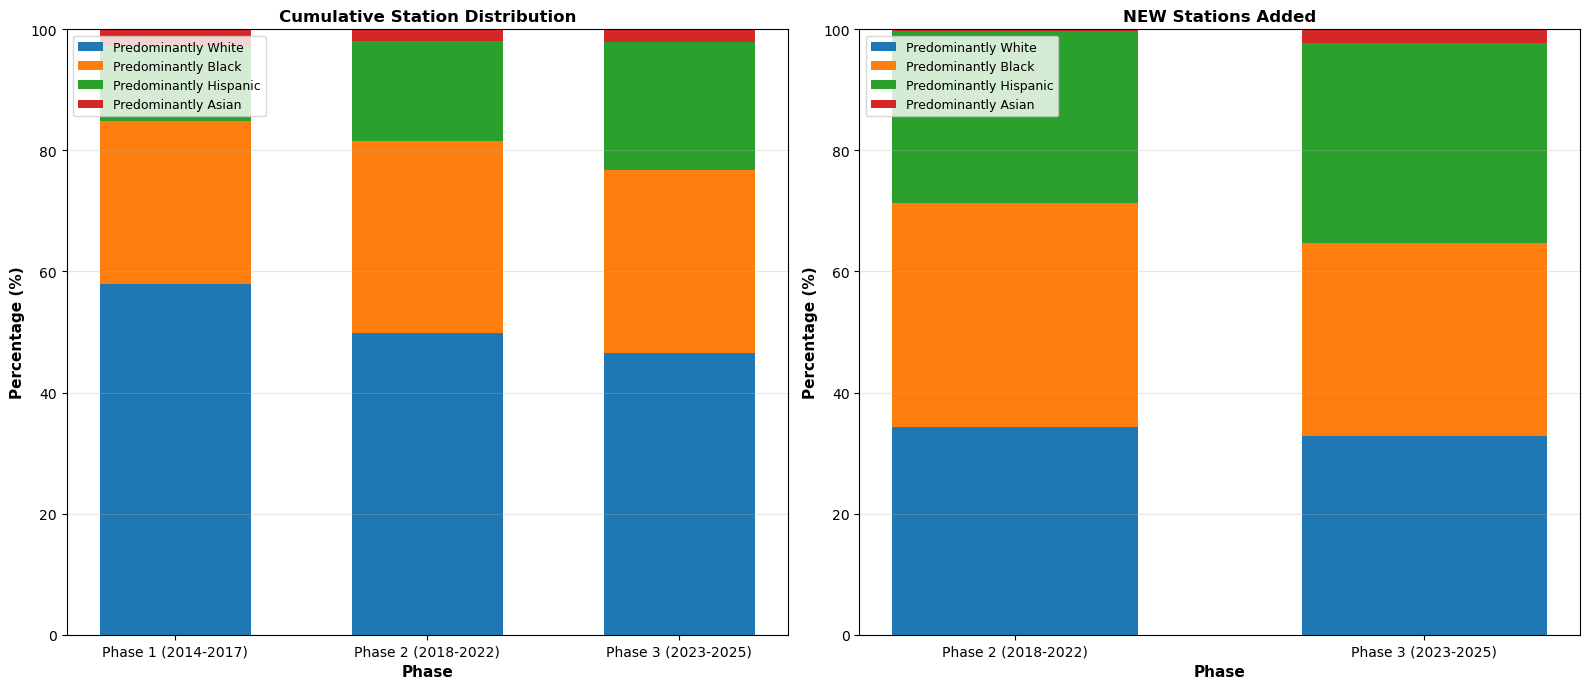

In [ ]:
# Create side-by-side charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

categories = ['Predominantly White', 'Predominantly Black', 'Predominantly Hispanic', 'Predominantly Asian']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Left: cumulative
phase_names_all = list(phases.keys())
x1 = np.arange(len(phase_names_all))
width = 0.6
bottom1 = np.zeros(len(phase_names_all))

for i, category in enumerate(categories):
    values = [cumulative_df[(cumulative_df['Phase'] == p) & (cumulative_df['Race Category'] == category)]['Percentage'].values[0] 
              for p in phase_names_all]
    ax1.bar(x1, values, width, label=category, bottom=bottom1, color=colors[i])
    bottom1 += values

ax1.set_xlabel('Phase', fontsize=11, fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
ax1.set_title('Cumulative Station Distribution', fontsize=12, fontweight='bold')
ax1.set_xticks(x1)
ax1.set_xticklabels(phase_names_all)
ax1.set_ylim(0, 100)
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# Right: new stations
phase_names_new = list(phases.keys())[1:]
x2 = np.arange(len(phase_names_new))
bottom2 = np.zeros(len(phase_names_new))

for i, category in enumerate(categories):
    values = [new_stations_df[(new_stations_df['Phase'] == p) & (new_stations_df['Race Category'] == category)]['Percentage'].values[0] 
              for p in phase_names_new]
    ax2.bar(x2, values, width, label=category, bottom=bottom2, color=colors[i])
    bottom2 += values

ax2.set_xlabel('Phase', fontsize=11, fontweight='bold')
ax2.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('NEW Stations Added', fontsize=12, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(phase_names_new)
ax2.set_ylim(0, 100)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Create geographic maps of station expansion

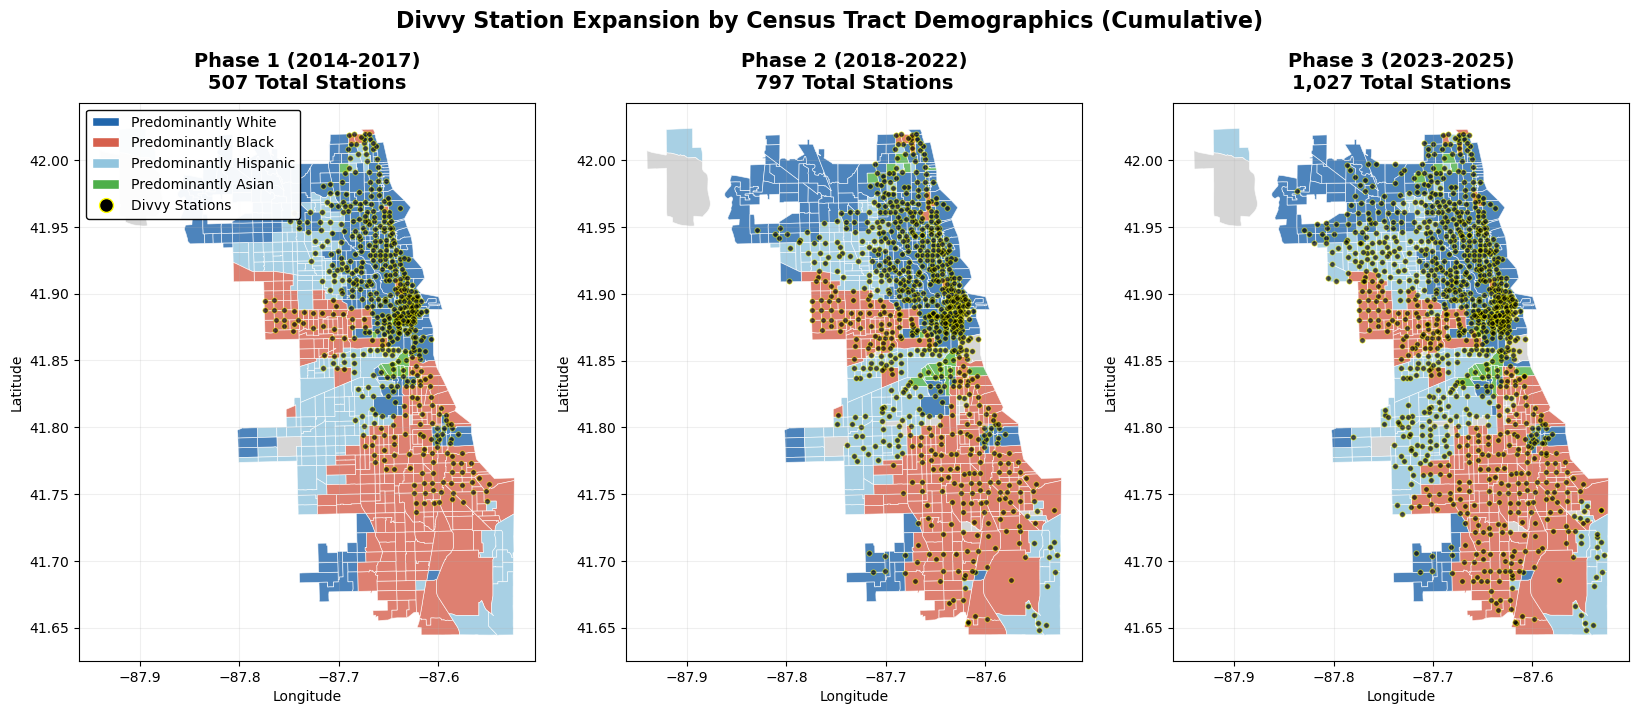

In [ ]:
# Merge census tracts with demographics
census_2017 = census_tracts.merge(demographics_2017[['geoid10', 'race_category']], on='geoid10', how='left')
census_2022 = census_tracts.merge(demographics_2022[['geoid10', 'race_category']], on='geoid10', how='left')
census_2023 = census_tracts.merge(demographics_2023[['geoid10', 'race_category']], on='geoid10', how='left')

# Prepare station data
stations_for_map = divvy_final[['start_station_name', 'latitude', 'longitude']].drop_duplicates()
stations_for_map = stations_for_map.merge(station_first_year, on='start_station_name', how='left')

# Convert to GeoDataFrame
from shapely.geometry import Point
stations_geo = gpd.GeoDataFrame(
    stations_for_map,
    geometry=[Point(xy) for xy in zip(stations_for_map['longitude'], stations_for_map['latitude'])],
    crs='EPSG:4326'
)

# Create 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Color mapping for race categories
race_color_map = {
    'Predominantly White': '#2166ac',
    'Predominantly Black': '#d6604d',
    'Predominantly Hispanic': '#92c5de',
    'Predominantly Asian': '#4daf4a'
}

phase_info = [
    ('Phase 1 (2014-2017)', 2017, census_2017, axes[0]),
    ('Phase 2 (2018-2022)', 2022, census_2022, axes[1]),
    ('Phase 3 (2023-2025)', 2025, census_2023, axes[2])
]

for phase_name, end_year, census_demo, ax in phase_info:
    # Create color column
    census_demo['color'] = census_demo['race_category'].map(race_color_map)
    census_demo['color'].fillna('#cccccc', inplace=True)
    
    # Plot census tracts with proper colors
    census_demo.plot(ax=ax, color=census_demo['color'], edgecolor='white', 
                     linewidth=0.5, alpha=0.8)
    
    # Plot cumulative stations
    phase_stations = stations_geo[stations_geo['first_year'] <= end_year]
    phase_stations.plot(ax=ax, color='black', markersize=15, alpha=0.7, 
                        edgecolor='yellow', linewidth=0.5)
    
    ax.set_title(f'{phase_name}\n{len(phase_stations):,} Total Stations', 
                 fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)
    ax.grid(True, alpha=0.2)

# Add legend to first plot
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=color, edgecolor='white', label=cat) 
                   for cat, color in race_color_map.items()]
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor='black', markersize=10, 
                                  markeredgecolor='yellow', linewidth=2, 
                                  label='Divvy Stations'))
axes[0].legend(handles=legend_elements, loc='upper left', fontsize=10, 
               framealpha=0.95, edgecolor='black')

plt.suptitle('Divvy Station Expansion by Census Tract Demographics (Cumulative)', 
             fontsize=16, fontweight='bold', y=0.96)
plt.show()

#### Analysis 2-2: Ridership Patterns

Calculate rides per census tract per year

In [ ]:
# Calculate rides by tract and year
rides_by_tract_year = divvy_final.groupby(['geoid10', 'year']).size().reset_index(name='ride_count')

print(f"Ride counts calculated: {len(rides_by_tract_year):,} tract-year combinations")

# Add ACS year mapping
rides_by_tract_year['acs_year'] = rides_by_tract_year['year'].apply(assign_acs_year)

# Merge with demographics
rides_with_demographics = rides_by_tract_year.merge(
    all_demographics[['geoid10', 'acs_year', 'race_category', 'income_category', 'total_pop']],
    on=['geoid10', 'acs_year'],
    how='left'
)

# Remove unmatched
rides_with_demographics = rides_with_demographics[rides_with_demographics['race_category'].notna()]

print(f"Merged with demographics: {len(rides_with_demographics):,} records")

Ride counts calculated: 4,168 tract-year combinations
Merged with demographics: 4,092 records


Aggregate ridership by race and year

In [ ]:
# Aggregate by year and race category
ridership_by_race_year = rides_with_demographics.groupby(['year', 'race_category']).agg({
    'ride_count': 'sum',
    'total_pop': 'sum'
}).reset_index()

# Calculate per capita
ridership_by_race_year['rides_per_capita'] = ridership_by_race_year['ride_count'] / ridership_by_race_year['total_pop']

print(ridership_by_race_year.head())

   year           race_category  ride_count  total_pop  rides_per_capita
0  2014     Predominantly Asian       19509    19590.0          0.995865
1  2014     Predominantly Black       23131    44785.0          0.516490
2  2014  Predominantly Hispanic       14450    44731.0          0.323042
3  2014     Predominantly White      524455   410466.0          1.277706
4  2015     Predominantly Asian       25329    24374.0          1.039181


Visualize ridership trends over time

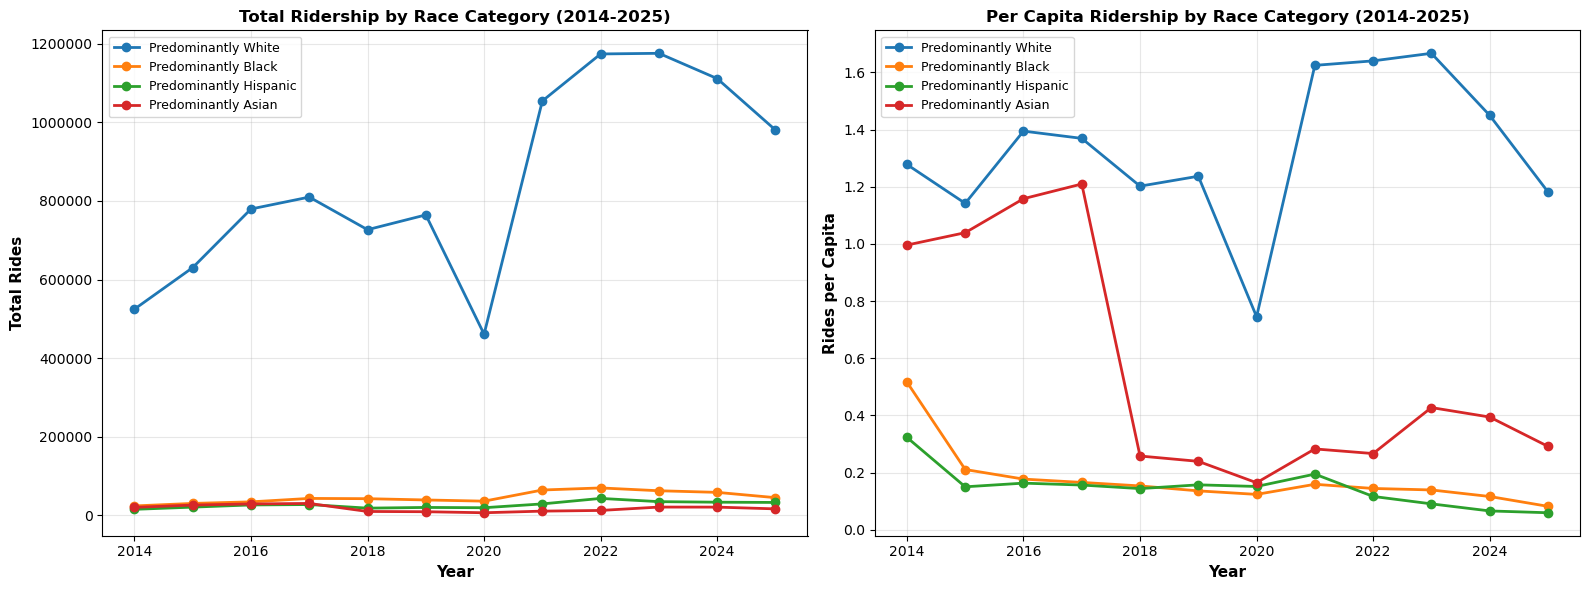

In [ ]:
# Create line chart for total rides and per capita rides
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

categories = ['Predominantly White', 'Predominantly Black', 'Predominantly Hispanic', 'Predominantly Asian']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Left: Total rides over time
for i, category in enumerate(categories):
    cat_data = ridership_by_race_year[ridership_by_race_year['race_category'] == category]
    ax1.plot(cat_data['year'], cat_data['ride_count'], marker='o', 
             linewidth=2, label=category, color=colors[i])

ax1.set_xlabel('Year', fontsize=11, fontweight='bold')
ax1.set_ylabel('Total Rides', fontsize=11, fontweight='bold')
ax1.set_title('Total Ridership by Race Category (2014-2025)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style='plain', axis='y')

# Right: Per capita rides over time
for i, category in enumerate(categories):
    cat_data = ridership_by_race_year[ridership_by_race_year['race_category'] == category]
    ax2.plot(cat_data['year'], cat_data['rides_per_capita'], marker='o', 
             linewidth=2, label=category, color=colors[i])

ax2.set_xlabel('Year', fontsize=11, fontweight='bold')
ax2.set_ylabel('Rides per Capita', fontsize=11, fontweight='bold')
ax2.set_title('Per Capita Ridership by Race Category (2014-2025)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Create ridership density maps

In [ ]:
# Calculate total rides per census tract for each phase
ridership_by_tract_phase = []

for phase_name, (start_year, end_year) in phases.items():
    phase_rides = divvy_final[divvy_final['year'].between(start_year, end_year)]
    tract_counts = phase_rides.groupby('geoid10').size().reset_index(name='ride_count')
    tract_counts['phase'] = phase_name
    ridership_by_tract_phase.append(tract_counts)

ridership_tract_df = pd.concat(ridership_by_tract_phase, ignore_index=True)

print(f"Ridership calculated for {ridership_tract_df['geoid10'].nunique()} census tracts")

Ridership calculated for 548 census tracts


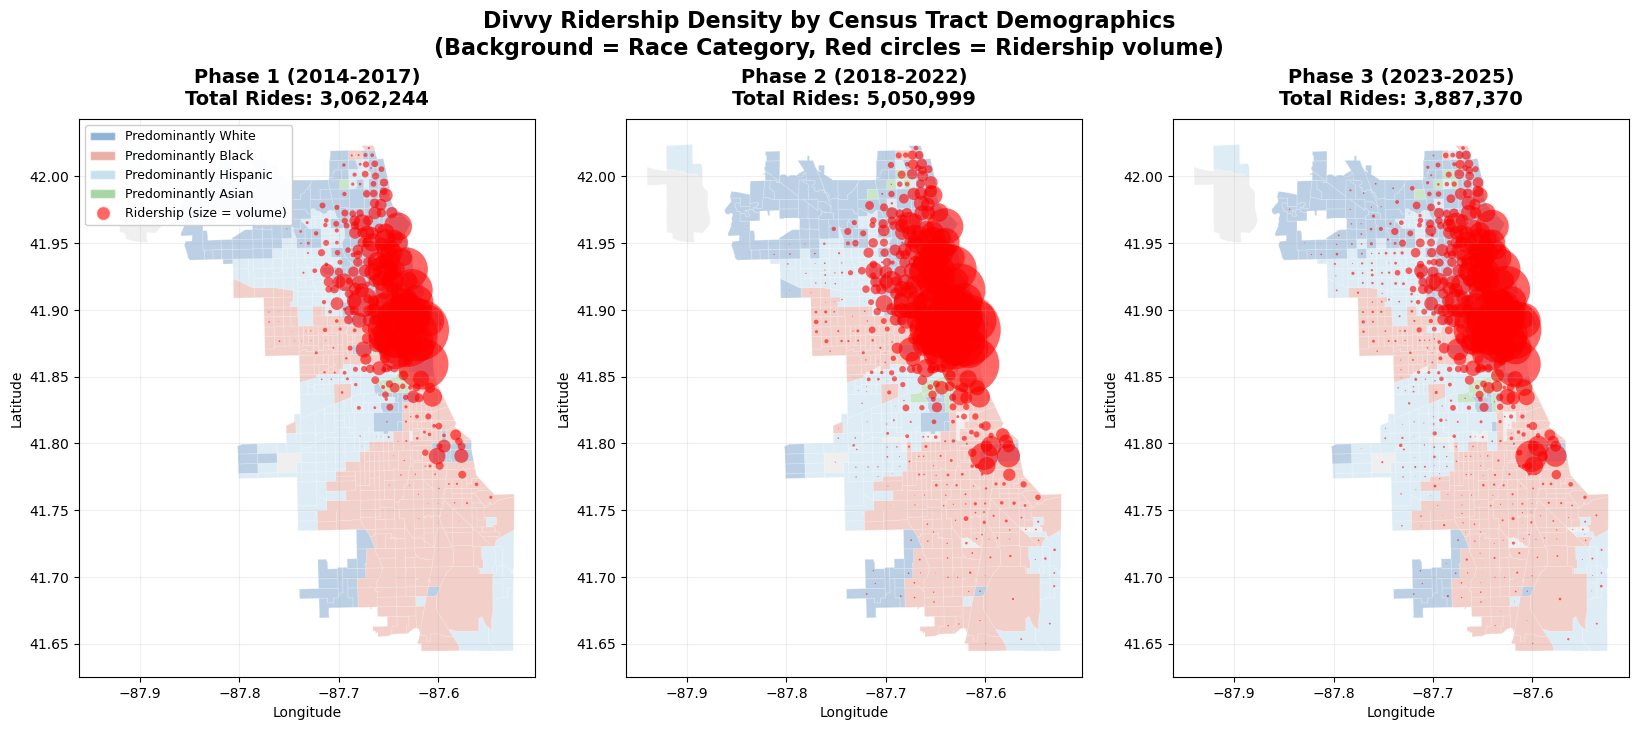

In [ ]:
# Create 3 maps
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

census_demo_list = [
    ('Phase 1 (2014-2017)', census_2017),
    ('Phase 2 (2018-2022)', census_2022),
    ('Phase 3 (2023-2025)', census_2023)
]

for idx, (phase_name, census_demo) in enumerate(census_demo_list):
    ax = axes[idx]
    
    # Get ridership for this phase
    phase_ridership = ridership_tract_df[ridership_tract_df['phase'] == phase_name]
    
    # Merge demographics and ridership
    census_with_rides = census_demo.merge(
        phase_ridership[['geoid10', 'ride_count']],
        on='geoid10',
        how='left'
    )
    census_with_rides['ride_count'].fillna(0, inplace=True)
    
    # Create base color from demographics
    census_with_rides['base_color'] = census_with_rides['race_category'].map(race_color_map)
    census_with_rides['base_color'].fillna('#cccccc', inplace=True)
    
    # Plot base layer (demographics) with subtle colors
    census_with_rides.plot(
        ax=ax,
        color=census_with_rides['base_color'],
        edgecolor='white',
        linewidth=0.5,
        alpha=0.3
    )
    
    # Overlay ridership density as circles
    tracts_with_rides = census_with_rides[census_with_rides['ride_count'] > 0].copy()
    tracts_with_rides['centroid'] = tracts_with_rides.geometry.centroid
    
    # Plot as scatter with size proportional to rides
    for _, row in tracts_with_rides.iterrows():
        ax.scatter(
            row['centroid'].x, 
            row['centroid'].y,
            s=row['ride_count'] / 100,
            c='red',
            alpha=0.6,
            edgecolors='none'
        )
    
    total_rides = census_with_rides['ride_count'].sum()
    ax.set_title(f'{phase_name}\nTotal Rides: {total_rides:,.0f}', 
                 fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)
    ax.grid(True, alpha=0.2)

# Add legend
legend_elements = [
    Patch(facecolor=color, edgecolor='white', alpha=0.5, label=cat) 
    for cat, color in race_color_map.items()
]
legend_elements.append(
    Line2D([0], [0], marker='o', color='w', 
          markerfacecolor='red', markersize=10, 
          alpha=0.6, label='Ridership (size = volume)')
)
axes[0].legend(handles=legend_elements, loc='upper left', fontsize=9, framealpha=0.95)

plt.suptitle('Divvy Ridership Density by Census Tract Demographics\n(Background = Race Category, Red circles = Ridership volume)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

#### Analysis 2-3: Equity Outcomes

Calculate per capita ridership by phase

In [ ]:
# Aggregate by phase
ridership_growth_data = []

for phase_name, (start_year, end_year) in phases.items():
    phase_data = rides_with_demographics[
        rides_with_demographics['year'].between(start_year, end_year)
    ]
    
    phase_summary = phase_data.groupby('race_category').agg({
        'ride_count': 'sum',
        'total_pop': 'sum'
    }).reset_index()
    
    phase_summary['rides_per_capita'] = phase_summary['ride_count'] / phase_summary['total_pop']
    phase_summary['phase'] = phase_name
    
    ridership_growth_data.append(phase_summary)

growth_df = pd.concat(ridership_growth_data, ignore_index=True)

# Print summary
print("\nPer Capita Ridership by Phase:")
for phase in phases.keys():
    print(f"\n{phase}:")
    phase_data = growth_df[growth_df['phase'] == phase]
    for _, row in phase_data.sort_values('rides_per_capita', ascending=False).iterrows():
        print(f"  {row['race_category']}: {row['rides_per_capita']:.3f} rides/person")


Per Capita Ridership by Phase:

Phase 1 (2014-2017):
  Predominantly White: 1.299 rides/person
  Predominantly Asian: 1.106 rides/person
  Predominantly Black: 0.204 rides/person
  Predominantly Hispanic: 0.172 rides/person

Phase 2 (2018-2022):
  Predominantly White: 1.304 rides/person
  Predominantly Asian: 0.243 rides/person
  Predominantly Black: 0.144 rides/person
  Predominantly Hispanic: 0.144 rides/person

Phase 3 (2023-2025):
  Predominantly White: 1.420 rides/person
  Predominantly Asian: 0.368 rides/person
  Predominantly Black: 0.111 rides/person
  Predominantly Hispanic: 0.070 rides/person


Calculate growth from Phase 1 to Phase 3

In [ ]:
# Calculate growth from Phase 1 to Phase 3
print()
print("GROWTH FROM PHASE 1 TO PHASE 3")

phase1 = growth_df[growth_df['phase'] == 'Phase 1 (2014-2017)'].set_index('race_category')
phase3 = growth_df[growth_df['phase'] == 'Phase 3 (2023-2025)'].set_index('race_category')

print("\nPer Capita Growth:")
for category in phase1.index:
    if category in phase3.index:
        early = phase1.loc[category, 'rides_per_capita']
        recent = phase3.loc[category, 'rides_per_capita']
        growth = ((recent - early) / early * 100) if early > 0 else 0
        print(f"  {category}:")
        print(f"    Phase 1: {early:.3f} rides/person")
        print(f"    Phase 3: {recent:.3f} rides/person")
        print(f"    Growth: {growth:+.1f}%")


GROWTH FROM PHASE 1 TO PHASE 3

Per Capita Growth:
  Predominantly Asian:
    Phase 1: 1.106 rides/person
    Phase 3: 0.368 rides/person
    Growth: -66.7%
  Predominantly Black:
    Phase 1: 0.204 rides/person
    Phase 3: 0.111 rides/person
    Growth: -45.8%
  Predominantly Hispanic:
    Phase 1: 0.172 rides/person
    Phase 3: 0.070 rides/person
    Growth: -59.2%
  Predominantly White:
    Phase 1: 1.299 rides/person
    Phase 3: 1.420 rides/person
    Growth: +9.3%


Visualize per capita comparison

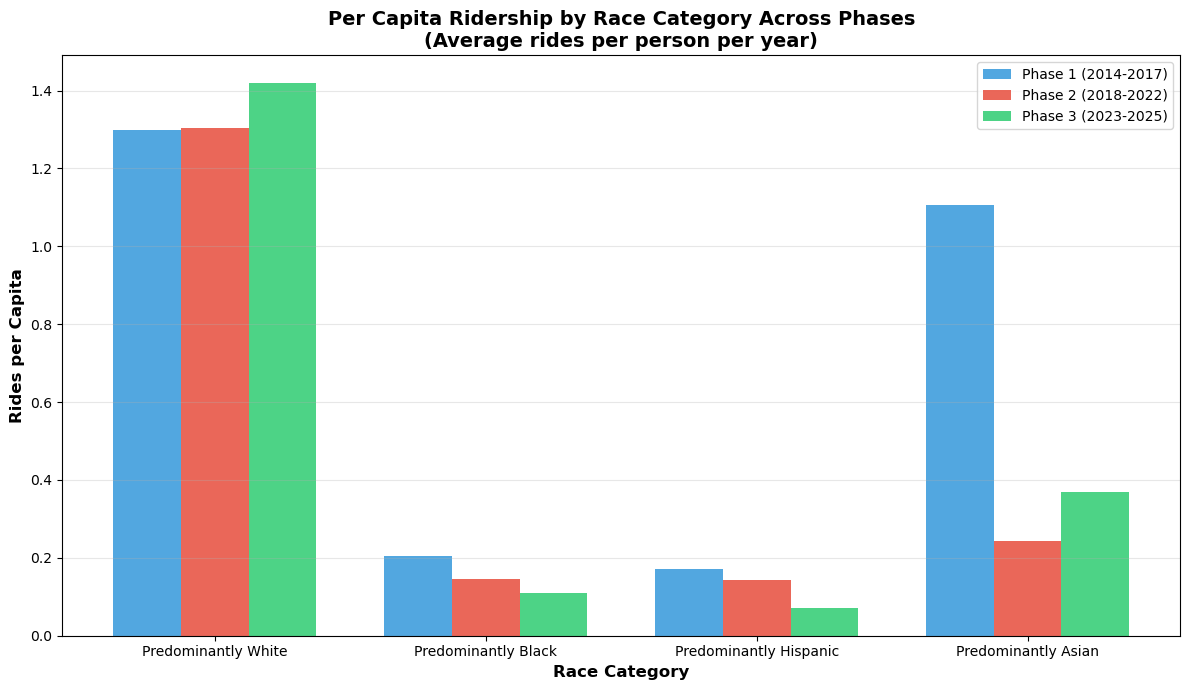

In [ ]:
# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 7))

categories = ['Predominantly White', 'Predominantly Black', 'Predominantly Hispanic', 'Predominantly Asian']
colors_phase = ['#3498db', '#e74c3c', '#2ecc71']

phase_names = list(phases.keys())
x = np.arange(len(categories))
width = 0.25

for i, phase in enumerate(phase_names):
    phase_data = growth_df[growth_df['phase'] == phase]
    values = [phase_data[phase_data['race_category'] == cat]['rides_per_capita'].values[0] 
              if len(phase_data[phase_data['race_category'] == cat]) > 0 else 0
              for cat in categories]
    offset = (i - 1) * width
    ax.bar(x + offset, values, width, label=phase, alpha=0.85, color=colors_phase[i])

ax.set_xlabel('Race Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Rides per Capita', fontsize=12, fontweight='bold')
ax.set_title('Per Capita Ridership by Race Category Across Phases\n(Average rides per person per year)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Calculate tract-level growth

In [ ]:
# Get Phase 1 and Phase 3 ridership by tract
phase1_rides = ridership_tract_df[ridership_tract_df['phase'] == 'Phase 1 (2014-2017)']
phase3_rides = ridership_tract_df[ridership_tract_df['phase'] == 'Phase 3 (2023-2025)']

# Merge to calculate growth
growth_data = phase1_rides[['geoid10', 'ride_count']].merge(
    phase3_rides[['geoid10', 'ride_count']],
    on='geoid10',
    how='outer',
    suffixes=('_phase1', '_phase3')
)

# Fill NaN with 0 (tracts that didn't have stations in one phase)
growth_data['ride_count_phase1'].fillna(0, inplace=True)
growth_data['ride_count_phase3'].fillna(0, inplace=True)

# Calculate percentage change
growth_data['pct_change'] = np.where(
    growth_data['ride_count_phase1'] > 0,
    ((growth_data['ride_count_phase3'] - growth_data['ride_count_phase1']) / 
     growth_data['ride_count_phase1'] * 100),
    np.where(growth_data['ride_count_phase3'] > 0, 300, 0)  # Cap new tracts at 300%
)

# Merge with census tracts and demographics
census_growth = census_2023.merge(
    growth_data[['geoid10', 'pct_change']], 
    on='geoid10', 
    how='left'
)
census_growth['pct_change'].fillna(0, inplace=True)

# Add demographics to growth_data for analysis
growth_with_demo = growth_data.merge(
    demographics_2023[['geoid10', 'race_category', 'income_category', 'median_income']],
    on='geoid10',
    how='left'
)

print(f"Growth data calculated for {len(growth_data)} tracts")
print(f"Tracts with growth: {(census_growth['pct_change'] > 0).sum()}")
print(f"Tracts with decline: {(census_growth['pct_change'] < 0).sum()}")

Growth data calculated for 548 tracts
Tracts with growth: 501
Tracts with decline: 47


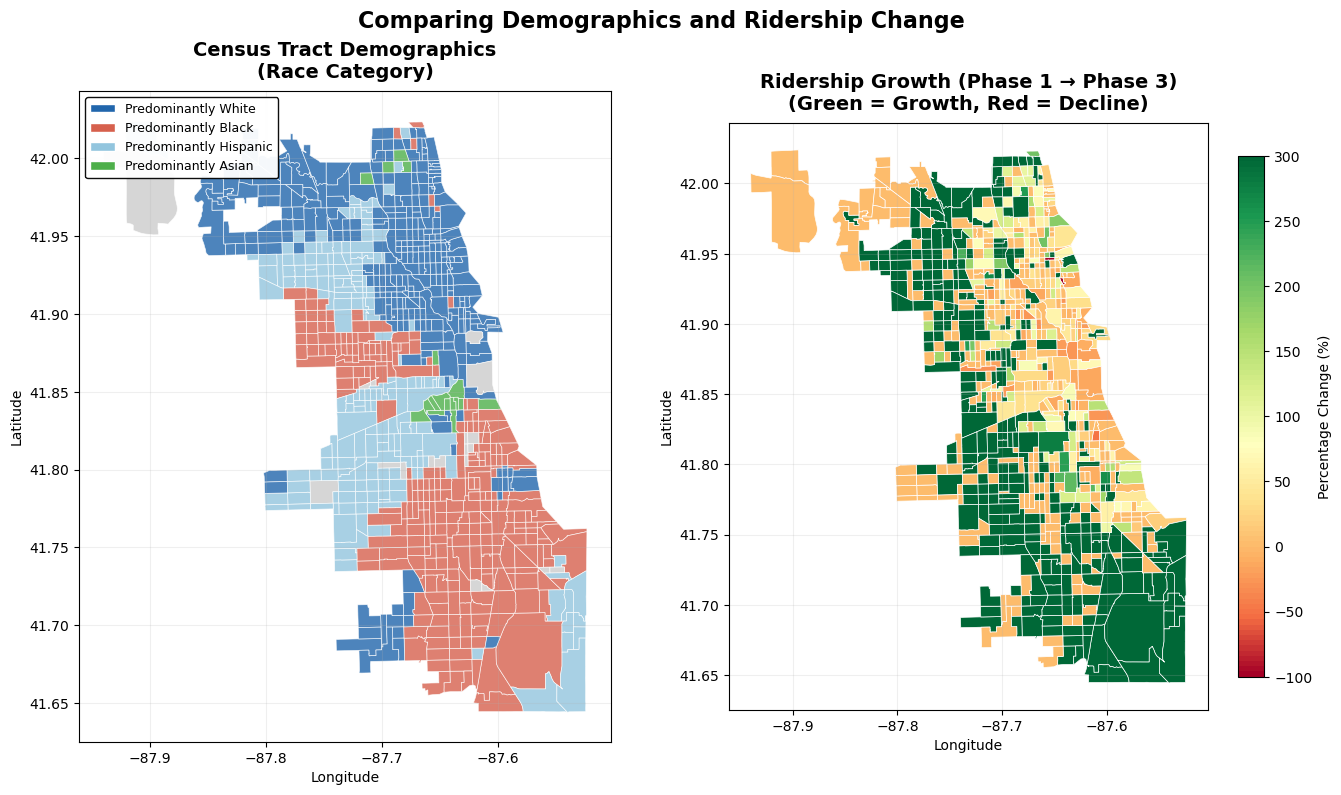

In [ ]:
# Visualize race categories and growth side-by-side

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Left map: Race category distribution
census_2023_colored = census_2023.copy()
census_2023_colored['color'] = census_2023_colored['race_category'].map(race_color_map)
census_2023_colored['color'].fillna('#cccccc', inplace=True)

census_2023_colored.plot(
    ax=ax1,
    color=census_2023_colored['color'],
    edgecolor='white',
    linewidth=0.5,
    alpha=0.8
)

ax1.set_title('Census Tract Demographics\n(Race Category)', 
              fontsize=14, fontweight='bold', pad=10)
ax1.set_xlabel('Longitude', fontsize=10)
ax1.set_ylabel('Latitude', fontsize=10)
ax1.grid(True, alpha=0.2)

# Add legend for race categories
legend_elements = [
    Patch(facecolor=color, edgecolor='white', label=cat) 
    for cat, color in race_color_map.items()
]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=9, 
           framealpha=0.95, edgecolor='black')

# Right map: Growth/decline
import matplotlib.colors as mcolors

# Clip extreme values for better visualization
census_growth['pct_change_clipped'] = census_growth['pct_change'].clip(-100, 300)

# Create custom colormap
colors_list = ['#a50026', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', 
               '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837']
n_bins = 100
cmap = mcolors.LinearSegmentedColormap.from_list('growth', colors_list, N=n_bins)

# Plot
census_growth.plot(
    column='pct_change_clipped',
    ax=ax2,
    cmap=cmap,
    edgecolor='white',
    linewidth=0.5,
    legend=True,
    legend_kwds={
        'label': 'Percentage Change (%)',
        'orientation': 'vertical',
        'shrink': 0.8,
        'pad': 0.05
    }
)

ax2.set_title('Ridership Growth (Phase 1 → Phase 3)\n(Green = Growth, Red = Decline)',
              fontsize=14, fontweight='bold', pad=10)
ax2.set_xlabel('Longitude', fontsize=10)
ax2.set_ylabel('Latitude', fontsize=10)
ax2.grid(True, alpha=0.2)

plt.suptitle('Comparing Demographics and Ridership Change', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
#### Identify tracts with most significant changes

print("\n" + "="*80)
print("CENSUS TRACTS WITH MOST SIGNIFICANT CHANGES")
print("="*80)

# Top 10 growth tracts (only among tracts that had ridership in Phase 1)
top_growth = growth_with_demo[growth_with_demo['ride_count_phase1'] > 0].nlargest(10, 'pct_change')

print("\nTop 10 Growth Tracts:")
print("-" * 80)
for idx, row in top_growth.iterrows():
    print(f"Tract {row['geoid10']}: {row['pct_change']:.1f}% growth")
    print(f"  Race: {row['race_category']}, Income: {row['income_category']}")
    print(f"  Phase 1: {row['ride_count_phase1']:.0f} rides → Phase 3: {row['ride_count_phase3']:.0f} rides")
    print()

print("\nGrowth Tracts - Demographic Summary:")
print(top_growth['race_category'].value_counts())
print("\nGrowth Tracts - Income Summary:")
print(top_growth['income_category'].value_counts())

# Top 10 decline tracts (only among tracts that had ridership in Phase 1)
top_decline = growth_with_demo[growth_with_demo['ride_count_phase1'] > 0].nsmallest(10, 'pct_change')

print("\n" + "-" * 80)
print("\nTop 10 Decline Tracts:")
print("-" * 80)
for idx, row in top_decline.iterrows():
    print(f"Tract {row['geoid10']}: {row['pct_change']:.1f}% decline")
    print(f"  Race: {row['race_category']}, Income: {row['income_category']}")
    print(f"  Phase 1: {row['ride_count_phase1']:.0f} rides → Phase 3: {row['ride_count_phase3']:.0f} rides")
    print()

print("\nDecline Tracts - Demographic Summary:")
print(top_decline['race_category'].value_counts())
print("\nDecline Tracts - Income Summary:")
print(top_decline['income_category'].value_counts())

# Overall pattern summary
print("\n" + "="*80)
print("KEY PATTERNS:")
print("="*80)

# Analyze by race category
race_growth = growth_with_demo[growth_with_demo['ride_count_phase1'] > 0].groupby('race_category').agg({
    'pct_change': 'median',
    'geoid10': 'count'
}).round(1)
race_growth.columns = ['Median % Change', 'Number of Tracts']

print("\nMedian Growth by Race Category (tracts with Phase 1 ridership):")
print(race_growth.sort_values('Median % Change', ascending=False))

print("\n" + "="*80)


CENSUS TRACTS WITH MOST SIGNIFICANT CHANGES

Top 10 Growth Tracts:
--------------------------------------------------------------------------------
Tract 17031431301: 4600.0% growth
  Race: Predominantly Black, Income: Low Income (<$50k)
  Phase 1: 3 rides → Phase 3: 141 rides

Tract 17031460200: 2828.6% growth
  Race: Predominantly Hispanic, Income: Low Income (<$50k)
  Phase 1: 7 rides → Phase 3: 205 rides

Tract 17031670200: 2700.0% growth
  Race: Predominantly Black, Income: High Income ($75-100k)
  Phase 1: 3 rides → Phase 3: 84 rides

Tract 17031610300: 2412.5% growth
  Race: Predominantly Hispanic, Income: Low Income (<$50k)
  Phase 1: 8 rides → Phase 3: 201 rides

Tract 17031671100: 2000.0% growth
  Race: Predominantly Black, Income: Low Income (<$50k)
  Phase 1: 4 rides → Phase 3: 84 rides

Tract 17031680600: 1866.7% growth
  Race: Predominantly Black, Income: Medium Income ($50-75k)
  Phase 1: 3 rides → Phase 3: 59 rides

Tract 17031691300: 1766.7% growth
  Race: Predominant

### Analysis 3
*By Eduardo Sourd*

### Analyze Trips by Membership Type

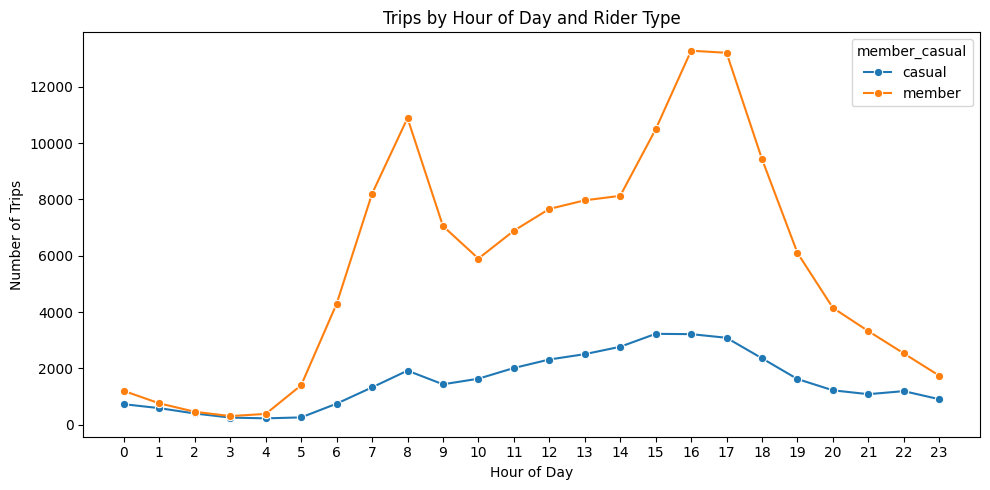

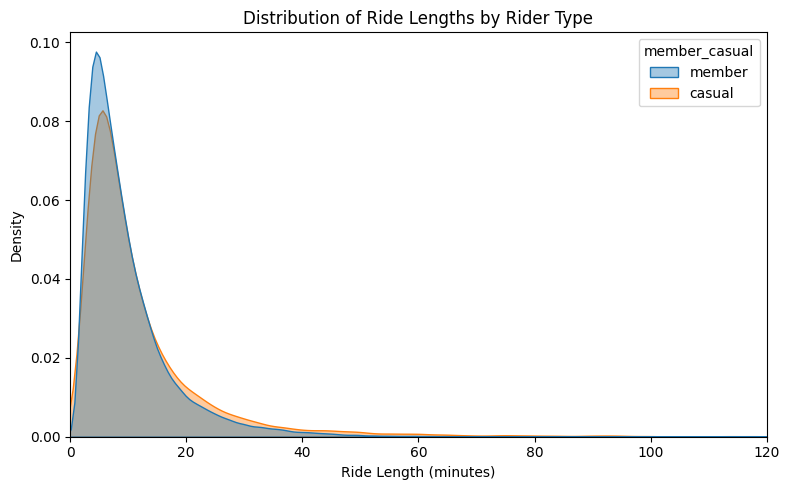

In [36]:
# Rides per hour of day by rider type
hourly_counts = (
    divvy_data_eduardo
    .groupby(['hour_of_day', 'member_casual'])['ride_id']
    .count()
    .reset_index(name='trip_count')
)

plt.figure(figsize=(10,5))
sns.lineplot(
    data=hourly_counts,
    x='hour_of_day',
    y='trip_count',
    hue='member_casual',
    marker='o'
)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Trips by Hour of Day and Rider Type')
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,5))

# Cap at 120 minutes for visibility
plot_data = divvy_data_eduardo[divvy_data_eduardo['ride_length_min'] <= 120].copy()

sns.kdeplot(
    data=plot_data,
    x='ride_length_min',
    hue='member_casual',
    fill=True,
    common_norm=False,
    alpha=0.4
)
plt.xlabel('Ride Length (minutes)')
plt.ylabel('Density')
plt.title('Distribution of Ride Lengths by Rider Type')
plt.xlim(0, 120)
plt.tight_layout()
plt.show()

### Create Heatmap to better visualize ride start times by membership type

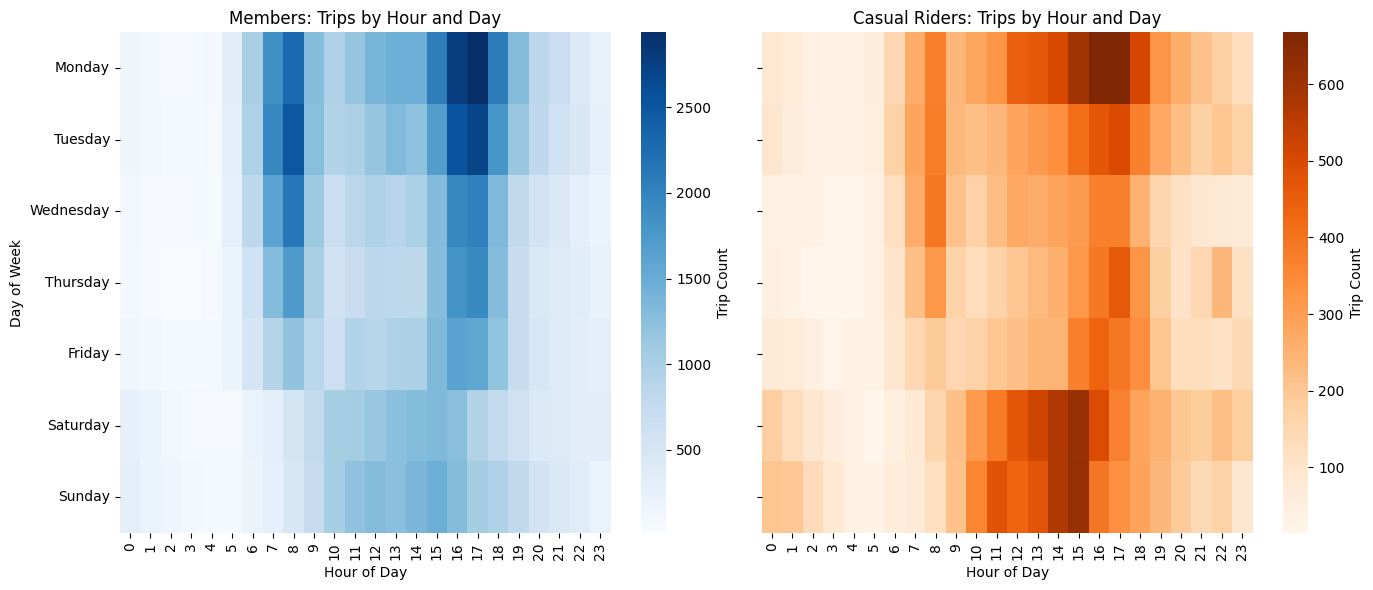

In [37]:
# Ensure a logical weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
divvy_data_eduardo['day_of_week'] = pd.Categorical(divvy_data_eduardo['day_of_week'], categories=weekday_order, ordered=True)


# Aggregate trips by hour and day for each rider type
hour_dow_counts = (
    divvy_data_eduardo
    .groupby(['member_casual', 'day_of_week', 'hour_of_day'], observed=True)['ride_id']
    .count()
    .reset_index(name='trip_count')
)

# Pivot into matrices for members and casuals
member_pivot = hour_dow_counts[hour_dow_counts['member_casual'] == 'member'].pivot(
    index='day_of_week', columns='hour_of_day', values='trip_count'
).reindex(index=weekday_order)

casual_pivot = hour_dow_counts[hour_dow_counts['member_casual'] == 'casual'].pivot(
    index='day_of_week', columns='hour_of_day', values='trip_count'
).reindex(index=weekday_order)

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

sns.heatmap(
    member_pivot,
    ax=axes[0],
    cmap='Blues',
    cbar_kws={'label': 'Trip Count'}
)
axes[0].set_title('Members: Trips by Hour and Day')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Day of Week')

sns.heatmap(
    casual_pivot,
    ax=axes[1],
    cmap='Oranges',
    cbar_kws={'label': 'Trip Count'}
)
axes[1].set_title('Casual Riders: Trips by Hour and Day')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


### Visualize Demographic-Ridership Relationships

In [38]:
# Demographic and Ridership Correlations

# Calculate income concentration percentages
income_total_cols = ['under_25k', 'income_25_50k', 'income_50_75k', 'income_75_125k', 'income_125k_plus']
for col in income_total_cols:
    total_income = community_summary[income_total_cols].sum(axis=1)
    community_summary[col + '_pct'] = (community_summary[col] / total_income * 100).round(1)

# Calculate racial composition percentages
race_total_cols = ['white', 'black_african_american', 'asian', 'hispanic_latino']
for col in race_total_cols:
    total_race = community_summary[race_total_cols].sum(axis=1)
    community_summary[col + '_pct'] = (community_summary[col] / total_race * 100).round(1)

# Correlation analysis: Demographics vs Member Share
demo_cols_for_corr = [
    'under_25k_pct', 'income_25_50k_pct', 'income_50_75k_pct', 'income_75_125k_pct', 'income_125k_plus_pct',
    'white_pct', 'black_african_american_pct', 'asian_pct', 'hispanic_latino_pct',
    'total_population', 'trips_per_1k_residents'
]

correlations_with_member_share = community_summary[demo_cols_for_corr + ['member_share']].corr()['member_share'].sort_values(ascending=False)

# Find strongest positive and negative demographic associations
top_positive_corr = correlations_with_member_share.drop('member_share').head(5)
top_negative_corr = correlations_with_member_share.drop('member_share').tail(5)

print("\nStrongest positive associations with member share:")
for var, corr in top_positive_corr.items():
    print(f"  {var}: {corr:.3f}")

print("\nStrongest negative associations with member share:")
for var, corr in top_negative_corr.items():
    print(f"  {var}: {corr:.3f}")


Strongest positive associations with member share:
  asian_pct: 0.404
  trips_per_1k_residents: 0.330
  total_population: 0.326
  income_125k_plus_pct: 0.254
  white_pct: 0.219

Strongest negative associations with member share:
  hispanic_latino_pct: -0.088
  income_25_50k_pct: -0.121
  black_african_american_pct: -0.204
  income_50_75k_pct: -0.294
  income_75_125k_pct: -0.314


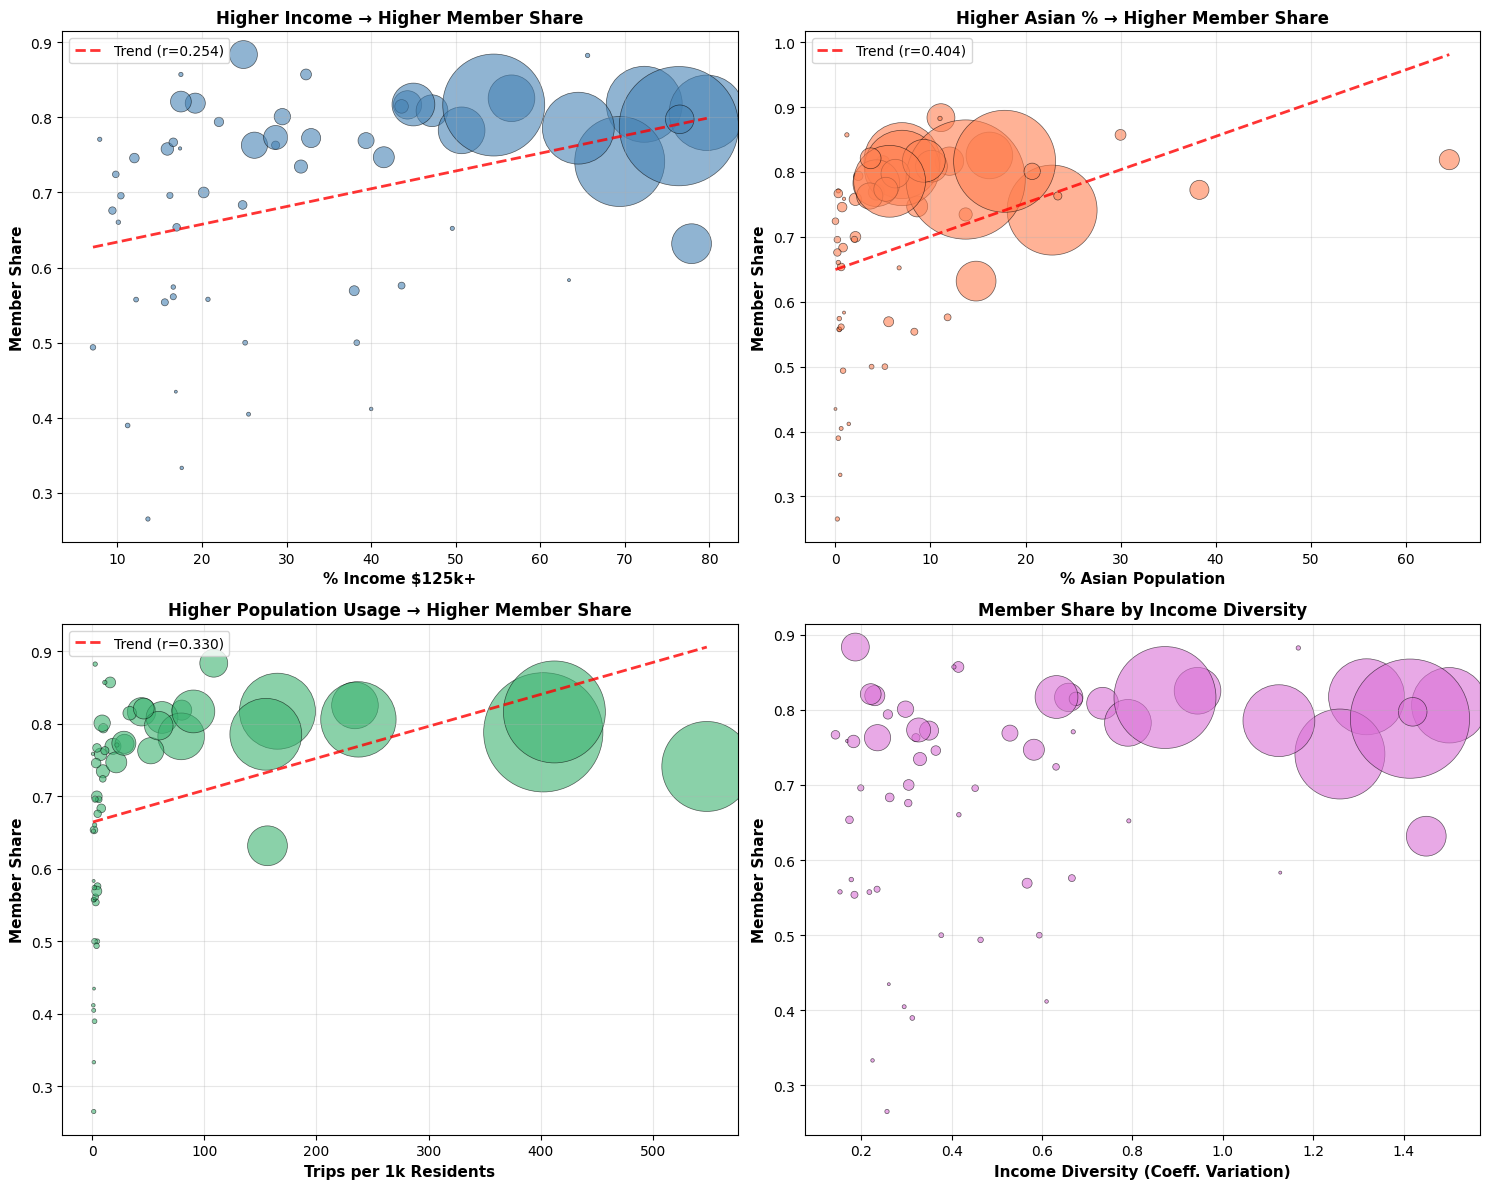

In [39]:
# Visualizations of Demographic-Ridership Relationships

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Income (Highest Bracket %) vs Member Share
ax1 = axes[0, 0]
scatter_data = community_summary[community_summary['total_trips'] > 20].copy()
ax1.scatter(scatter_data['income_125k_plus_pct'], scatter_data['member_share'], 
            s=scatter_data['total_trips']/5, alpha=0.6, color='steelblue', edgecolors='black', linewidth=0.5)
z = np.polyfit(scatter_data['income_125k_plus_pct'].dropna(), 
               scatter_data.loc[scatter_data['income_125k_plus_pct'].notna(), 'member_share'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(scatter_data['income_125k_plus_pct'].min(), scatter_data['income_125k_plus_pct'].max(), 100)
ax1.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend (r={correlations_with_member_share["income_125k_plus_pct"]:.3f})')
ax1.set_xlabel('% Income $125k+', fontsize=11, fontweight='bold')
ax1.set_ylabel('Member Share', fontsize=11, fontweight='bold')
ax1.set_title('Higher Income → Higher Member Share', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Asian % vs Member Share
ax2 = axes[0, 1]
ax2.scatter(scatter_data['asian_pct'], scatter_data['member_share'], 
            s=scatter_data['total_trips']/5, alpha=0.6, color='coral', edgecolors='black', linewidth=0.5)
z = np.polyfit(scatter_data['asian_pct'].dropna(), 
               scatter_data.loc[scatter_data['asian_pct'].notna(), 'member_share'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(scatter_data['asian_pct'].min(), scatter_data['asian_pct'].max(), 100)
ax2.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend (r={correlations_with_member_share["asian_pct"]:.3f})')
ax2.set_xlabel('% Asian Population', fontsize=11, fontweight='bold')
ax2.set_ylabel('Member Share', fontsize=11, fontweight='bold')
ax2.set_title('Higher Asian % → Higher Member Share', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Population Density (Trips per 1k) vs Member Share
ax3 = axes[1, 0]
density_data = scatter_data[scatter_data['trips_per_1k_residents'].notna()]
ax3.scatter(density_data['trips_per_1k_residents'], density_data['member_share'], 
            s=density_data['total_trips']/5, alpha=0.6, color='mediumseagreen', edgecolors='black', linewidth=0.5)
z = np.polyfit(density_data['trips_per_1k_residents'], density_data['member_share'], 1)
p = np.poly1d(z)
x_line = np.linspace(density_data['trips_per_1k_residents'].min(), density_data['trips_per_1k_residents'].max(), 100)
ax3.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend (r={correlations_with_member_share["trips_per_1k_residents"]:.3f})')
ax3.set_xlabel('Trips per 1k Residents', fontsize=11, fontweight='bold')
ax3.set_ylabel('Member Share', fontsize=11, fontweight='bold')
ax3.set_title('Higher Population Usage → Higher Member Share', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Income Diversity (Coefficient of Variation) vs Member Share
ax4 = axes[1, 1]
diversity_data = scatter_data[scatter_data['income_diversity_cv'].notna()]
ax4.scatter(diversity_data['income_diversity_cv'], diversity_data['member_share'], 
            s=diversity_data['total_trips']/5, alpha=0.6, color='orchid', edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Income Diversity (Coeff. Variation)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Member Share', fontsize=11, fontweight='bold')
ax4.set_title('Member Share by Income Diversity', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Analysis 4
*By Isabella Yan (Chisa)*

#### Step 1: Check distribution of data and log transform to avoid right skewedness

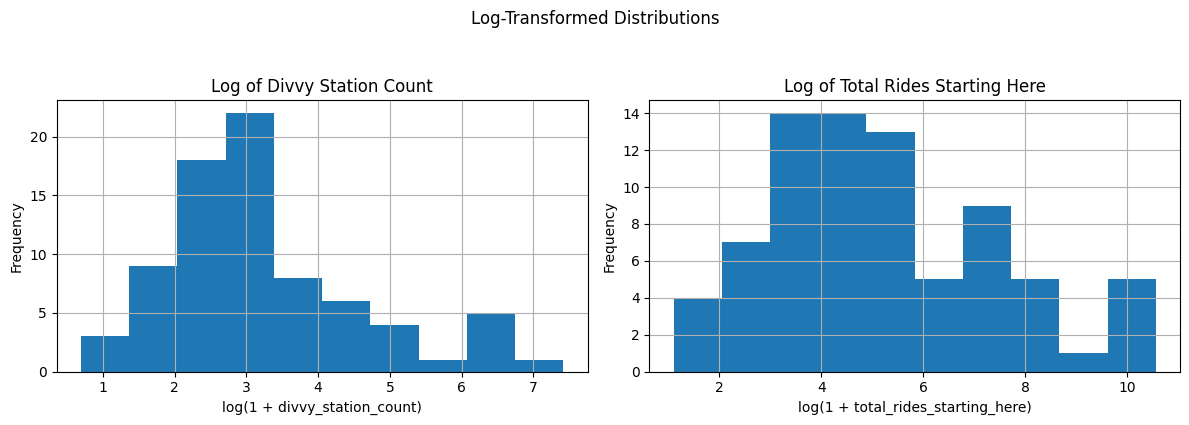

In [40]:
#
# 1.1. Check distribution of data
#

cols = [
    'physical_inactivity_rate',
    'traffic_crashes',
    'divvy_station_count',
    'total_rides_starting_here'
]

# Log-transformed histograms (for skewed variables)
log_cols = ['divvy_station_count', 'total_rides_starting_here']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Compute log-transformed data
log_data = community_stats[log_cols].apply(np.log1p)

# Plot histograms
log_data.hist(ax=axes)

# Add titles and axis labels
axes[0].set_title("Log of Divvy Station Count")
axes[0].set_xlabel("log(1 + divvy_station_count)")
axes[0].set_ylabel("Frequency")

axes[1].set_title("Log of Total Rides Starting Here")
axes[1].set_xlabel("log(1 + total_rides_starting_here)")
axes[1].set_ylabel("Frequency")

fig.suptitle("Log-Transformed Distributions", y=1.05)

plt.tight_layout()
plt.show()


#### Step 2: Observe correlations between key variables

In [41]:
#
# 2.1. Look at correlations
#
community_stats[['physical_inactivity_rate',
                 'traffic_crashes',
                 'divvy_station_count',
                 'total_rides_starting_here']].corr()


,physical_inactivity_rate,traffic_crashes,divvy_station_count,total_rides_starting_here
physical_inactivity_rate,1.000000,-0.177478,-0.468223,-0.490147
traffic_crashes,-0.177478,1.000000,0.643516,0.670118
divvy_station_count,-0.468223,0.643516,1.000000,0.974841
total_rides_starting_here,-0.490147,0.670118,0.974841,1.000000


#### Step 3: Use scatterplots to visualize relationships between variables

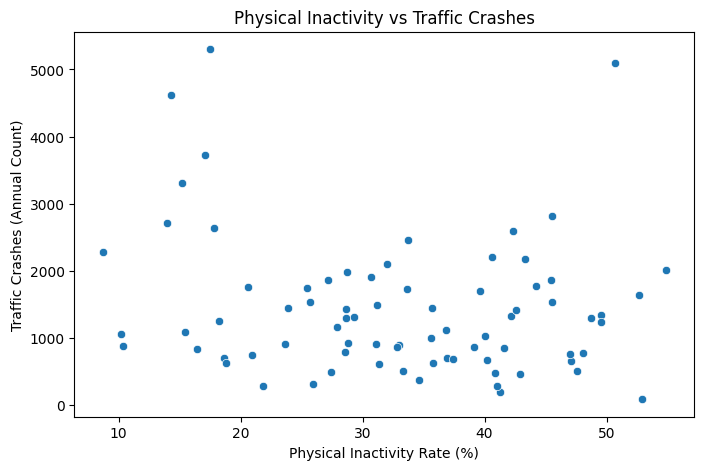

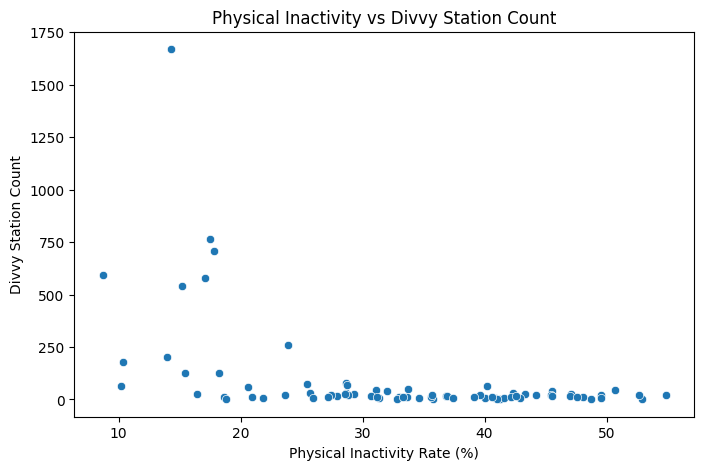

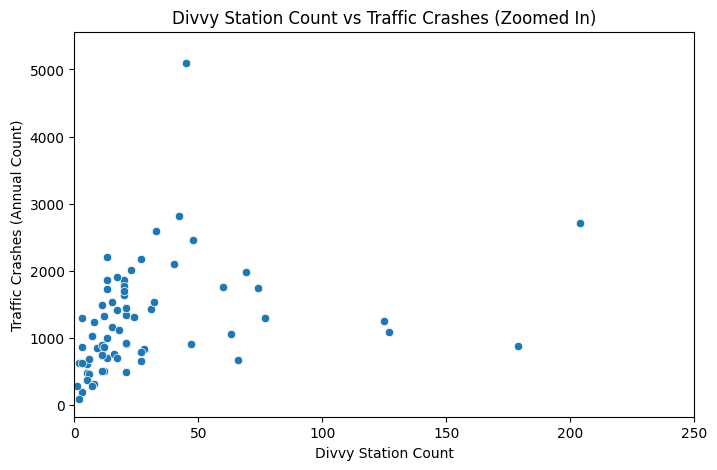

In [42]:
#
# 3.1. Use scatterplots to visualize relationships
#

# convert to numeric values
community_stats['physical_inactivity_rate'] = pd.to_numeric(
    community_stats['physical_inactivity_rate'], errors='coerce'
)

community_stats['traffic_crashes'] = pd.to_numeric(
    community_stats['traffic_crashes'], errors='coerce'
)

community_stats['divvy_station_count'] = pd.to_numeric(
    community_stats['divvy_station_count'], errors='coerce'
)

# Physical inactivity vs traffic crashes
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=community_stats,
    x='physical_inactivity_rate',
    y='traffic_crashes'
)
plt.xlabel("Physical Inactivity Rate (%)")
plt.ylabel("Traffic Crashes (Annual Count)")
plt.title("Physical Inactivity vs Traffic Crashes")
plt.show()

# Physical inactivity vs Divvy station count
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=community_stats,
    x='physical_inactivity_rate',
    y='divvy_station_count'
)
plt.xlabel("Physical Inactivity Rate (%)")
plt.ylabel("Divvy Station Count")
plt.title("Physical Inactivity vs Divvy Station Count")
plt.show()

# Divvy station count vs traffic crashes (zoomed)
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=community_stats,
    x='divvy_station_count',
    y='traffic_crashes'
)
plt.xlim(0, 250)   # zoom for better visibility
plt.xlabel("Divvy Station Count")
plt.ylabel("Traffic Crashes (Annual Count)")
plt.title("Divvy Station Count vs Traffic Crashes (Zoomed In)")
plt.show()

#### Step 4: Create choropleths to visualize key variable distribution in the context of Chicago community areas

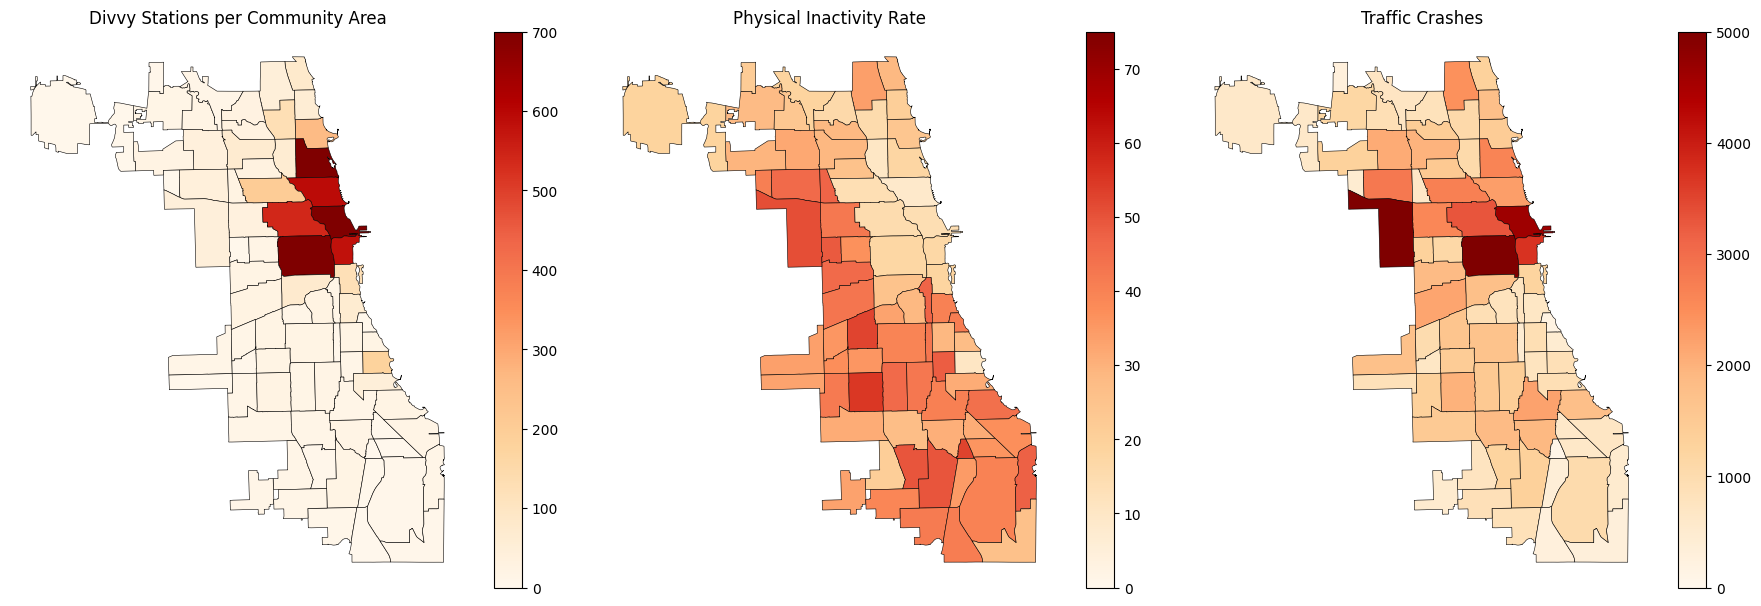

In [43]:
#
# 5.4 Create maps with key variables
#
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# convert WKT geometry column to shapely
community_boundary_data["geometry"] = community_boundary_data["wkt_geometry"].apply(wkt.loads)

gdf = gpd.GeoDataFrame(
    community_boundary_data,
    geometry="geometry",
    crs="EPSG:4326"
)

gdf["community_area_number"] = gdf["community_area_number"].astype(int)
community_stats["community_area_number"] = community_stats["community_area_number"].astype(int)

# merge 
gdf_merged = gdf.merge(community_stats, on="community_area_number", how="left")

# boundary geometry becomes geometry_x
gdf_merged = gdf_merged.set_geometry("geometry_x")

# remove centroid geometry from stats
if "geometry_y" in gdf_merged.columns:
    gdf_merged = gdf_merged.drop(columns=["geometry_y"])

# 3 variables we want to map 
columns_to_map = [
    ("divvy_station_count", "Divvy Stations per Community Area", 0, 700),
    ("physical_inactivity_rate", "Physical Inactivity Rate", 0, 75),
    ("traffic_crashes", "Traffic Crashes", 0, 5000),
]

# set up 3 plots 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

for ax, (col, title, vmin, vmax) in zip(axes, columns_to_map):
    gdf_merged.plot(
        column=col,
        cmap="OrRd",
        legend=True,
        vmin=vmin,
        vmax=vmax,
        edgecolor="black",
        linewidth=0.4,
        ax=ax
    )
    ax.set_title(title, fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()
